In [2]:
#| hide
#| eval: false
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline

In [3]:
from fastbook import *
from katlas.core import Data
# from katlas.feature import *
# from katlas.plot import *
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import numpy as np

# Prepare target for training

> We will try several methods to transform the target data for better prediction

In this module, we will show you two methods to transform data:
- Standardize
- Percentile Rank

## Get data

In [59]:
# Download raw peptide library screening data
raw = Data.get_kinase_raw()

In [60]:
raw = raw.set_index('kinase')

In [5]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

In [9]:
raw.shape

(303, 207)

## Standardize

Apply (x - mean) / std to each kinase

In [61]:
rawT = raw.T

In [62]:
rawT.head(2)

kinase,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,AMPKA2,ANKRD3,ASK1,ATM,ATR,AURA,AURB,AURC,BCKDK,BIKE,BMPR1A,BMPR1B,BMPR2,BRAF,BRSK1,BRSK2,BUB1,CAMK1A,CAMK1B,CAMK1D,CAMK1G,CAMK2A,CAMK2B,CAMK2D,CAMK2G,CAMK4,CAMKK1,CAMKK2,CAMLCK,CDC7,CDK1,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,CDK8,CDK9,CDK10,CDK12,CDK13,CDK14,CDK16,CDK17,CDK18,CDK19,CDKL1,CDKL5,CHAK1,CHAK2,CHK1,CHK2,CK1A,CK1A2,CK1D,CK1E,CK1G1,CK1G2,CK1G3,CK2A1,CK2A2,CLK1,CLK2,CLK3,CLK4,COT,CRIK,DAPK1,DAPK2,DAPK3,DCAMKL1,DCAMKL2,DLK,DMPK1,DNAPK,DRAK1,DSTYK,DYRK1A,DYRK1B,DYRK2,DYRK3,DYRK4,EEF2K,ERK1,ERK2,ERK5,ERK7,FAM20C,GAK,GCK,GCN2,GRK1,GRK2,GRK3,GRK4,GRK5,GRK6,GRK7,GSK3A,GSK3B,HASPIN,HGK,HIPK1,HIPK2,HIPK3,HIPK4,HPK1,HRI,HUNK,ICK,IKKA,IKKB,IKKE,IRAK1,IRAK4,IRE1,IRE2,JNK1,JNK2,JNK3,KHS1,KHS2,KIS,LATS1,LATS2,LKB1,LOK,LRRK2,MAK,MAP3K15,MAPKAPK2,MAPKAPK3,MAPKAPK5,MARK1,MARK2,MARK3,MARK4,MASTL,MEK1,MEK2,MEK5,MEKK1,MEKK2,MEKK3,MEKK6,MELK,MINK,MLK1,MLK2,MLK3,MLK4,MNK1,MNK2,MOK,MOS,MPSK1,MRCKA,MRCKB,MSK1,MSK2,MST1,MST2,MST3,MST4,MTOR,MYLK4,MYO3A,MYO3B,NDR1,NDR2,NEK1,NEK2,NEK3,NEK4,NEK5,NEK6,NEK7,NEK8,NEK9,NEK11,NIK,NIM1,NLK,NUAK1,NUAK2,OSR1,P38A,P38B,P38D,P38G,P70S6K,P70S6KB,P90RSK,PAK1,PAK2,PAK3,PAK4,PAK5,PAK6,PASK,PBK,PDHK1,PDHK4,PDK1,PERK,PHKG1,PHKG2,PIM1,PIM2,PIM3,PINK1,PKACA,PKACB,PKACG,PKCA,PKCB,PKCD,PKCE,PKCG,PKCH,PKCI,PKCT,PKCZ,PKG1,PKG2,PKN1,PKN2,PKN3,PKR,PLK1,PLK2,PLK3,PLK4,PRKD1,PRKD2,PRKD3,PRKX,PRP4,PRPK,QIK,QSK,RAF1,RIPK1,RIPK2,RIPK3,ROCK1,ROCK2,RSK2,RSK3,RSK4,SBK,SGK1,SGK3,SIK,SKMLCK,SLK,SMG1,SMMLCK,SNRK,SRPK1,SRPK2,SRPK3,SSTK,STK33,STLK3,TAK1,TAO1,TAO2,TAO3,TBK1,TGFBR1,TGFBR2,TLK1,TLK2,TNIK,TSSK1,TSSK2,TTBK1,TTBK2,TTK,ULK1,ULK2,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
-5P,7614134.38,4991039.28,26480329.10,18399509.29,5439237.54,8559223.07,13734100.62,16173668.51,505390.80,88641374.20,45096733.42,6847501.78,26315134.18,5758257.76,4405709.36,5683377.86,17381301.39,42813997.89,9010435.93,13186365.51,2904462.06,13231412.07,14112792.66,13504910.48,6030894.83,22272478.91,7863670.65,11130261.38,4661272.71,43405153.37,8081689.51,16296830.39,1.147482e+08,64678309.72,4962511.42,67824811.3,217467027.3,15709088.74,2007302.88,12098942.33,62888209.42,188487472.1,16036829.58,18966216.44,437309818.5,18092241.04,14569785.70,72221781.0,58079354.90,4224140.37,21058088.69,11054686.61,26071401.44,5671280.89,42832651.02,20856490.56,19395383.82,6154621.93,981164.61,41803759.34,80908183.0,20544727.59,24267659.40,4793630.36,3688790.33,8926441.25,500313.15,11885594.75,2958.601,4534938.46,1686871.28,3855686.26,28123114.51,10767399.51,6412371.30,13305095.07,297993384.3,2322489.50,6460439.89,4970892.82,22752841.64,90426819.52,25838727.05,11779364.33,5265395.18,13569645.91,7793041.43,8.210529e+07,7260981.87,20090376.10,21213057.35,9900071.39,31409996.74,88208093.60,34169406.99,46092045.78,17200553.31,35494363.45,31931898.77,3108621.60,176074122.2,17474045.05,11690282.31,41297356.0,3202891.75,22431875.01,4866604.38,7878572.11,3436132.24,4987510.02,365927.00,14111104.57,101793007.6,108885068.0,65419274.09,12371933.51,33658938.04,68771223.85,15495773.08,38832368.50,16153500.58,40156613.28,8.356848e+07,431048214.3,6.898713e+07,415105517.5,139760676.0,15271695.69,10891933.74,27810435.21,69659520.10,253145478.2,112191772.0,1219408.33,8886739.05,25003398.72,1.004792e+08,70869527.48,20000548.46,20952180.25,25741653.46,1.633461e+08,90932376.32,16211057.35,6812740.46,27834035.79,11594516.97,53142783.96,24171928.57,5352364.04,22986755.45,3926992.37,135081845.1,126167310.0,12627910.18,149046673.0,96348026.86,8.966681e+07,138864687.7,160704249.6,16866323.72,33053715.55,11989282.9,68043137.15,11588970.33,13881027.82,9255303.93,19972096.55,8451019.75,16635158.35,7317953.46,46976646.34,612591700.6,122938054.7,14592310.95,17050155.23,5475862.60,92557203.80,103587127.0,16502636.05,13748380.03,117030179.4,9.584926e+07,195807338.3,303158327.8,195949994.8,39631667.89,54352212.17,154258995.0,199453521.4,14384302.26,10119780.68,15074645.66,13779452.73,5968776.23,55055698.0,9328261.01,17419626.22,34041121.

In [63]:
scaler = StandardScaler()

In [64]:
scaler.fit(rawT)
X = scaler.transform(rawT)

In [65]:
scaled = rawT.copy()

In [66]:
scaled[scaled.columns] = X

In [67]:
scaled.head(2)

kinase,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,AMPKA2,ANKRD3,ASK1,ATM,ATR,AURA,AURB,AURC,BCKDK,BIKE,BMPR1A,BMPR1B,BMPR2,BRAF,BRSK1,BRSK2,BUB1,CAMK1A,CAMK1B,CAMK1D,CAMK1G,CAMK2A,CAMK2B,CAMK2D,CAMK2G,CAMK4,CAMKK1,CAMKK2,CAMLCK,CDC7,CDK1,CDK2,CDK3,CDK4,CDK5,CDK6,CDK7,CDK8,CDK9,CDK10,CDK12,CDK13,CDK14,CDK16,CDK17,CDK18,CDK19,CDKL1,CDKL5,CHAK1,CHAK2,CHK1,CHK2,CK1A,CK1A2,CK1D,CK1E,CK1G1,CK1G2,CK1G3,CK2A1,CK2A2,CLK1,CLK2,CLK3,CLK4,COT,CRIK,DAPK1,DAPK2,DAPK3,DCAMKL1,DCAMKL2,DLK,DMPK1,DNAPK,DRAK1,DSTYK,DYRK1A,DYRK1B,DYRK2,DYRK3,DYRK4,EEF2K,ERK1,ERK2,ERK5,ERK7,FAM20C,GAK,GCK,GCN2,GRK1,GRK2,GRK3,GRK4,GRK5,GRK6,GRK7,GSK3A,GSK3B,HASPIN,HGK,HIPK1,HIPK2,HIPK3,HIPK4,HPK1,HRI,HUNK,ICK,IKKA,IKKB,IKKE,IRAK1,IRAK4,IRE1,IRE2,JNK1,JNK2,JNK3,KHS1,KHS2,KIS,LATS1,LATS2,LKB1,LOK,LRRK2,MAK,MAP3K15,MAPKAPK2,MAPKAPK3,MAPKAPK5,MARK1,MARK2,MARK3,MARK4,MASTL,MEK1,MEK2,MEK5,MEKK1,MEKK2,MEKK3,MEKK6,MELK,MINK,MLK1,MLK2,MLK3,MLK4,MNK1,MNK2,MOK,MOS,MPSK1,MRCKA,MRCKB,MSK1,MSK2,MST1,MST2,MST3,MST4,MTOR,MYLK4,MYO3A,MYO3B,NDR1,NDR2,NEK1,NEK2,NEK3,NEK4,NEK5,NEK6,NEK7,NEK8,NEK9,NEK11,NIK,NIM1,NLK,NUAK1,NUAK2,OSR1,P38A,P38B,P38D,P38G,P70S6K,P70S6KB,P90RSK,PAK1,PAK2,PAK3,PAK4,PAK5,PAK6,PASK,PBK,PDHK1,PDHK4,PDK1,PERK,PHKG1,PHKG2,PIM1,PIM2,PIM3,PINK1,PKACA,PKACB,PKACG,PKCA,PKCB,PKCD,PKCE,PKCG,PKCH,PKCI,PKCT,PKCZ,PKG1,PKG2,PKN1,PKN2,PKN3,PKR,PLK1,PLK2,PLK3,PLK4,PRKD1,PRKD2,PRKD3,PRKX,PRP4,PRPK,QIK,QSK,RAF1,RIPK1,RIPK2,RIPK3,ROCK1,ROCK2,RSK2,RSK3,RSK4,SBK,SGK1,SGK3,SIK,SKMLCK,SLK,SMG1,SMMLCK,SNRK,SRPK1,SRPK2,SRPK3,SSTK,STK33,STLK3,TAK1,TAO1,TAO2,TAO3,TBK1,TGFBR1,TGFBR2,TLK1,TLK2,TNIK,TSSK1,TSSK2,TTBK1,TTBK2,TTK,ULK1,ULK2,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
-5P,0.203681,-0.497906,-0.274530,-0.138624,-0.052269,0.046099,-0.257893,-0.007065,-0.071429,-0.265121,-0.223020,-0.012917,0.677768,-0.149366,0.000190,-0.314236,-0.015094,0.139422,-0.343371,0.133850,-0.485807,-0.055673,-0.234016,0.717053,-0.222931,-0.219497,0.693476,0.734658,-0.073604,0.100034,-0.055709,0.109544,-0.278402,0.054396,-0.38394,-0.392706,1.073584,1.097241,0.348853,-0.409752,0.232128,0.800020,0.469049,0.383122,0.861967,0.440937,0.154827,0.034128,0.140190,0.049870,0.300067,0.463659,0.098435,0.103601,0.164713,0.253202,-0.143858,0.010173,-0.107188,0.612396,-0.201058,-1.296830,-0.147280,-0.091720,-0.139679,-0.126772,-0.172026,-0.170110,-0.168112,-0.139680,-0.407787,-0.259000,-0.095733,-0.186920,-0.293092,-0.085313,0.874637,-0.351356,-0.357839,0.211357,-0.143431,0.075682,-0.080648,-0.265675,-0.003846,0.112291,-0.222867,0.215391,0.347762,0.092460,0.007091,-0.027549,0.020825,-0.150002,0.364978,0.159620,0.227102,0.226437,-0.198188,-0.792222,0.198973,-0.430332,0.666804,-0.201939,-0.329453,-0.247318,-0.403009,-0.454609,-0.228835,-0.088387,-0.111166,0.330429,0.417155,0.323368,0.384235,0.191933,0.223679,0.125091,-0.38143,0.034211,0.141724,-0.056768,-0.208073,0.075618,-0.401547,0.785998,-0.213965,-0.025315,0.397745,0.634359,0.396169,0.604519,0.140055,-0.026270,-0.576537,-0.345316,2.420710,0.473847,-0.098665,0.796017,0.415722,0.123462,0.176430,-0.417003,-0.413064,-0.372252,-0.120159,-0.324398,0.181135,0.259251,-0.004368,-0.411567,0.132042,-0.341269,-0.950167,0.223933,0.050651,-0.091002,-0.558175,0.834001,0.728358,0.174953,0.081701,0.265107,0.043140,0.596182,0.945395,-0.285983,-0.147728,-0.353726,-0.192863,1.010848,0.248661,0.222938,-0.455919,1.08367,-0.117475,0.141371,0.589376,-0.322945,-0.643696,1.187763,0.474545,-0.325102,0.811091,1.748314,0.389386,-0.335364,0.536580,0.200687,0.423075,0.363327,-0.232661,0.223719,-0.554514,-0.676291,0.526736,0.747387,0.408283,-0.183957,0.337223,-0.466136,-0.368047,-0.045347,0.334625,-0.048336,0.301482,0.070993,0.039057,-0.068657,-0.800427,-0.009012,-0.695551,-1.367195,0.192385,-0.249038,0.071854,-0.405812,-0.323729,-0.219181,-0.497184,-0.034317,-0.006494,0.157522,-0.259625,0.149018,0.216979,0.416697,-0.200136,-0.180151,-0.344241,-0.212332,0.044866,0.153313,-0.119938,0.261478,-0.109642,-0.249393,-0.175310,-0.431234,-0.137170,-0.019395,0.275033,-0.259775,0.2185

In [68]:
# Transpose back
scaled = scaled.T

Save the scaler for future use

In [39]:
dump(scaler, 'standard_scaler.joblib')

['standard_scaler.joblib']

In [56]:
# Reload
scaler2 = load('standard_scaler.joblib')

In [57]:
scaler.scale_[:5] == scaler2.scale_[:5] # check std value

array([ True,  True,  True,  True,  True])

In [58]:
scaler.mean_[:5] == scaler2.mean_[:5] # check mean value

array([ True,  True,  True,  True,  True])

Visualize the transformation

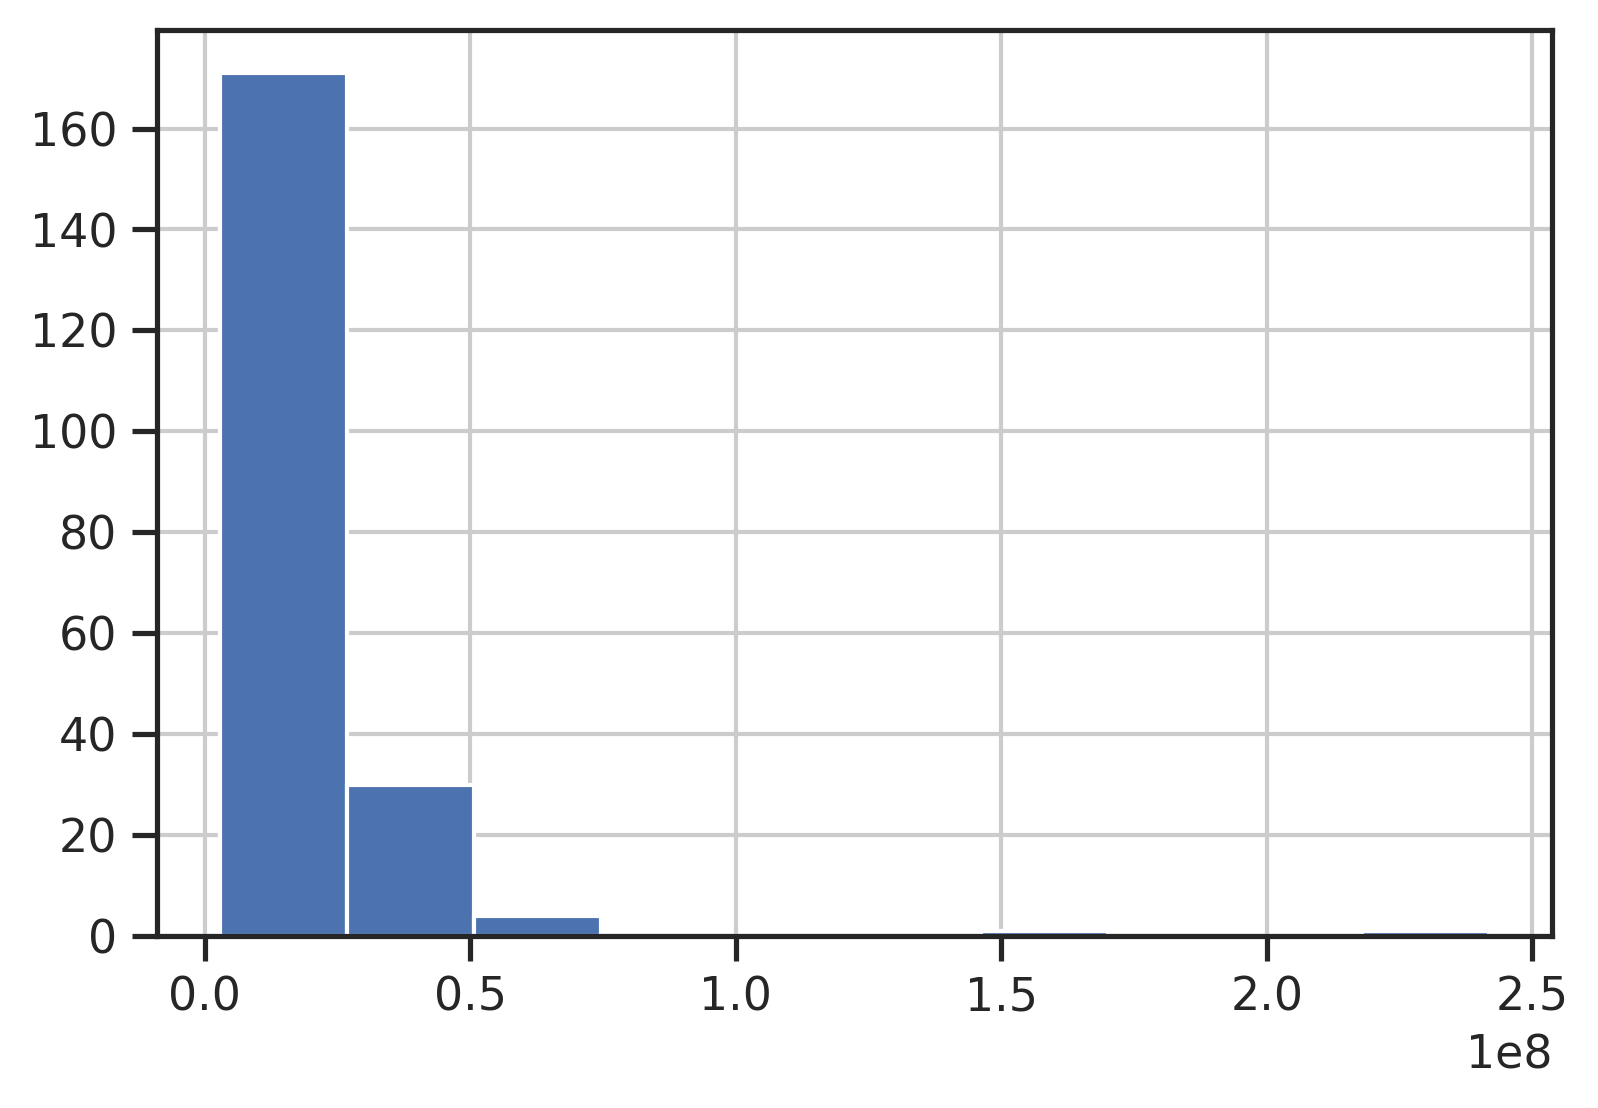

In [116]:
rawT['AKT1'].hist();

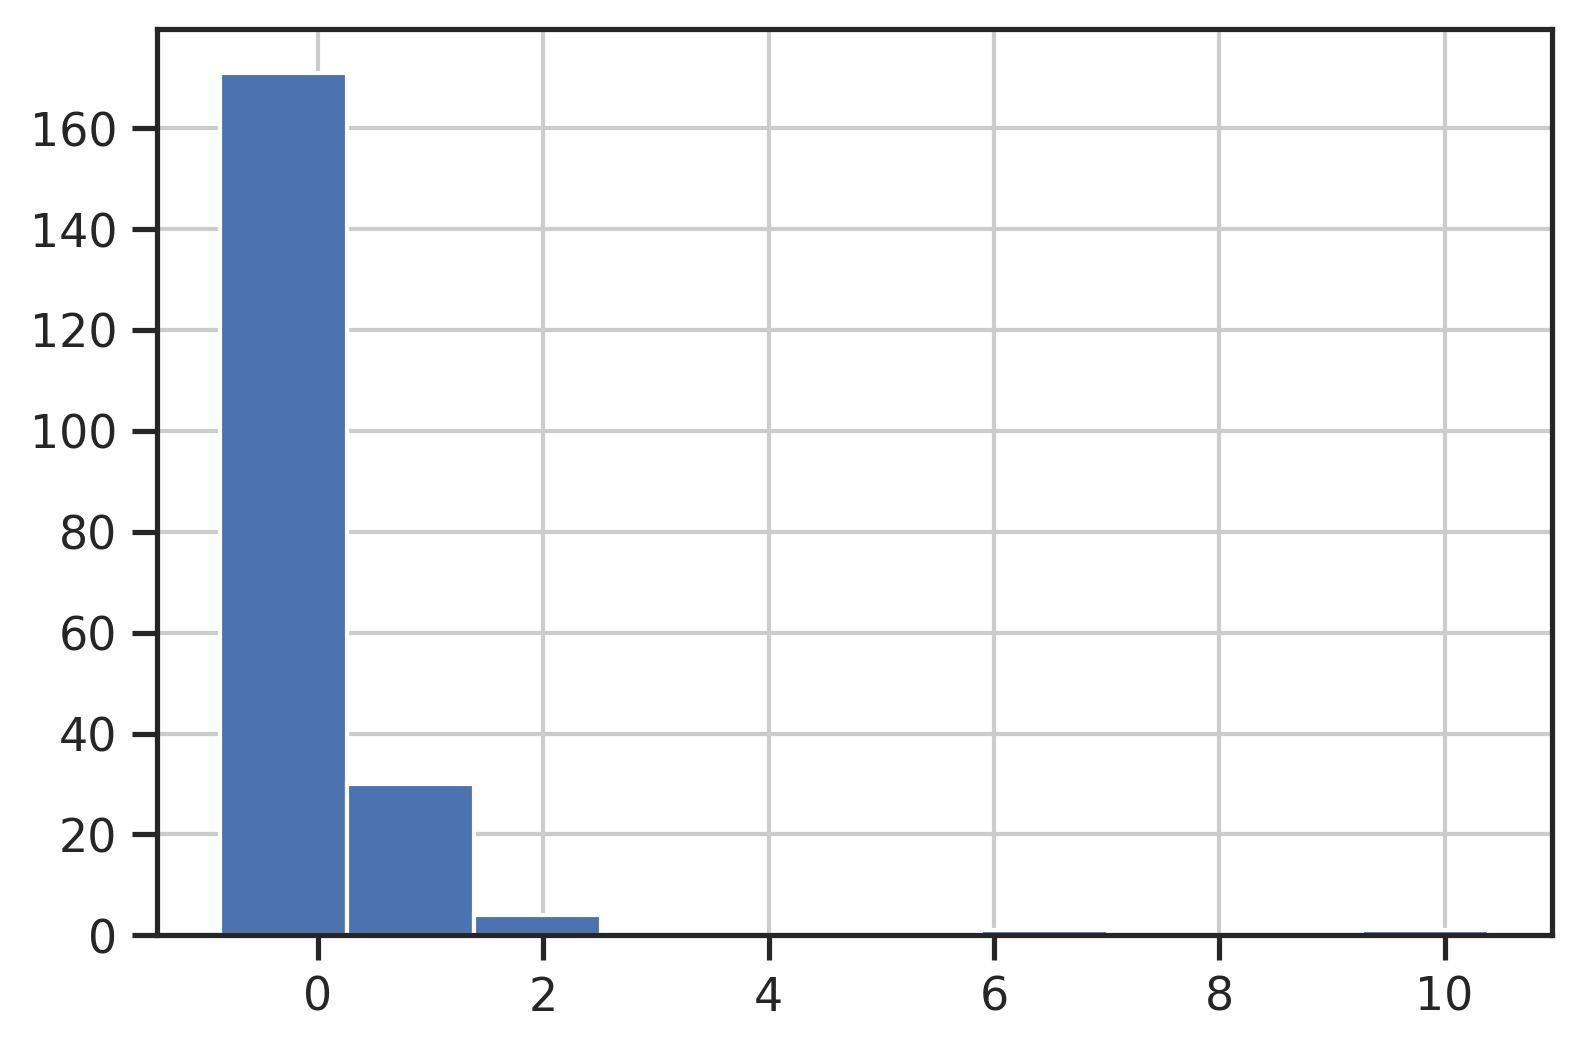

In [117]:
scaled['AKT1'].hist();

In [74]:
# Visualize distribution of each kinase, it will take some time to load
# scaled.hist(bins=40,figsize=(50,600),layout=(200,2));

## Log transformation

In [155]:
log = np.log(raw + 1)

<AxesSubplot:>

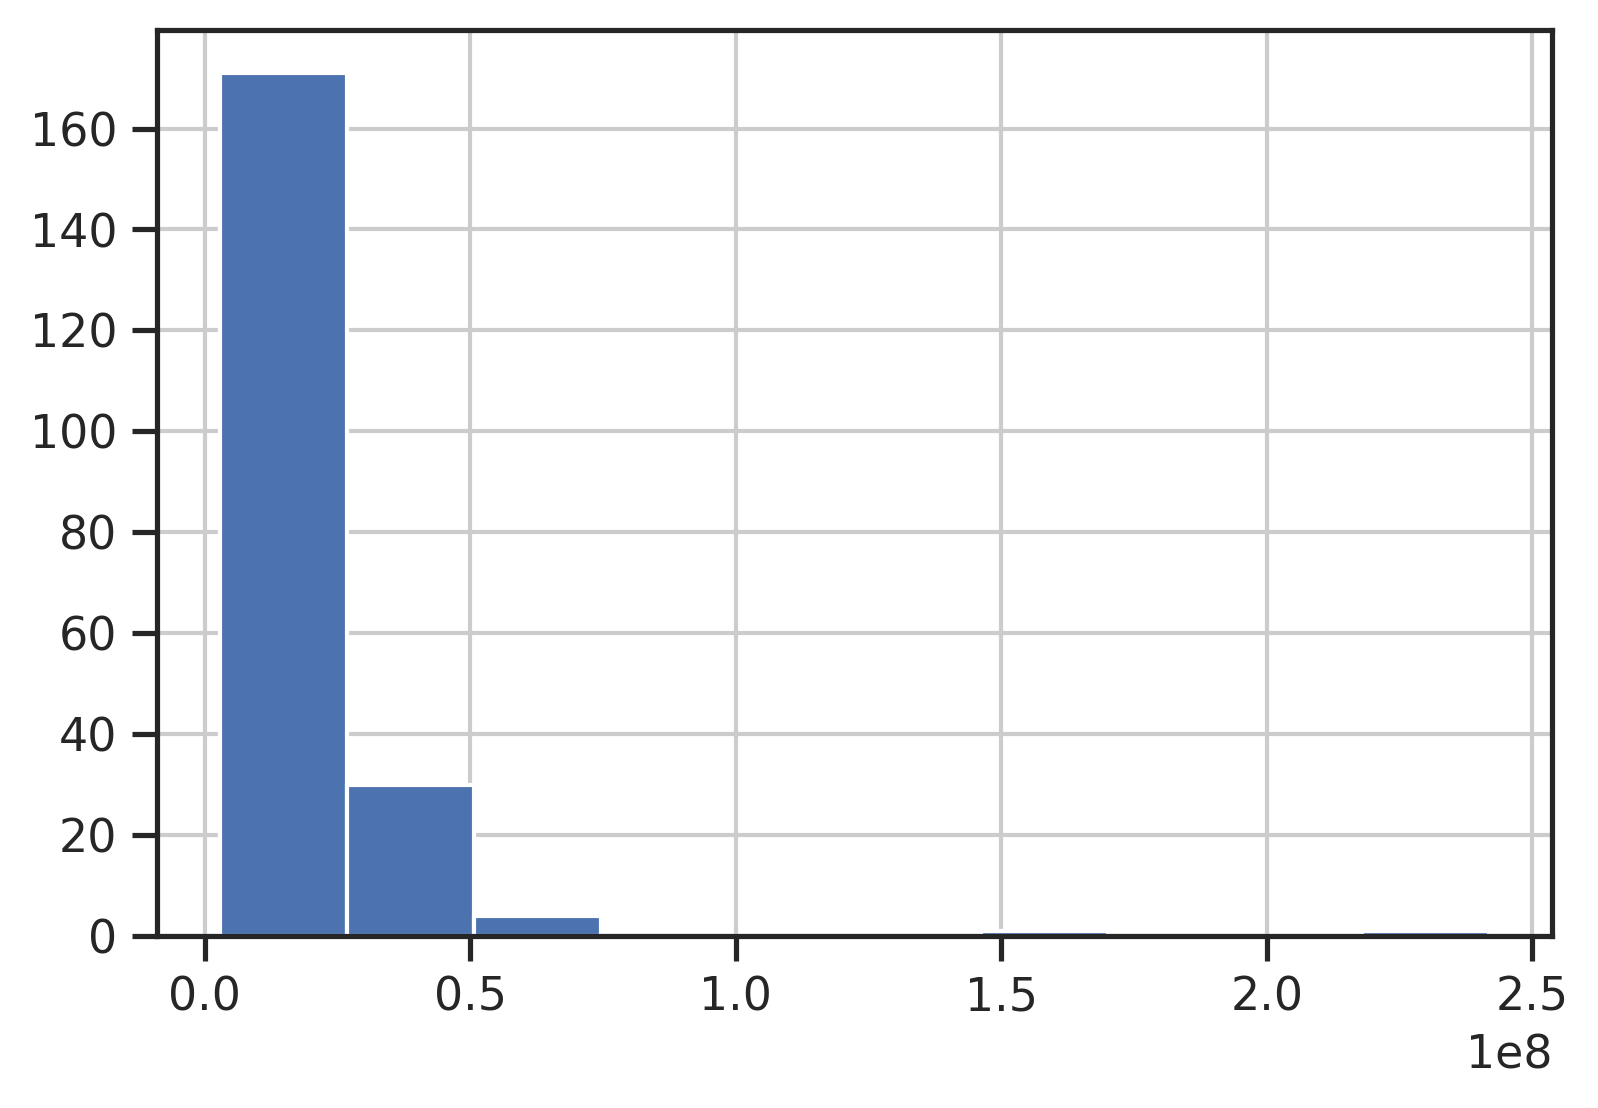

In [114]:
raw.loc['AKT1'].hist()

<AxesSubplot:>

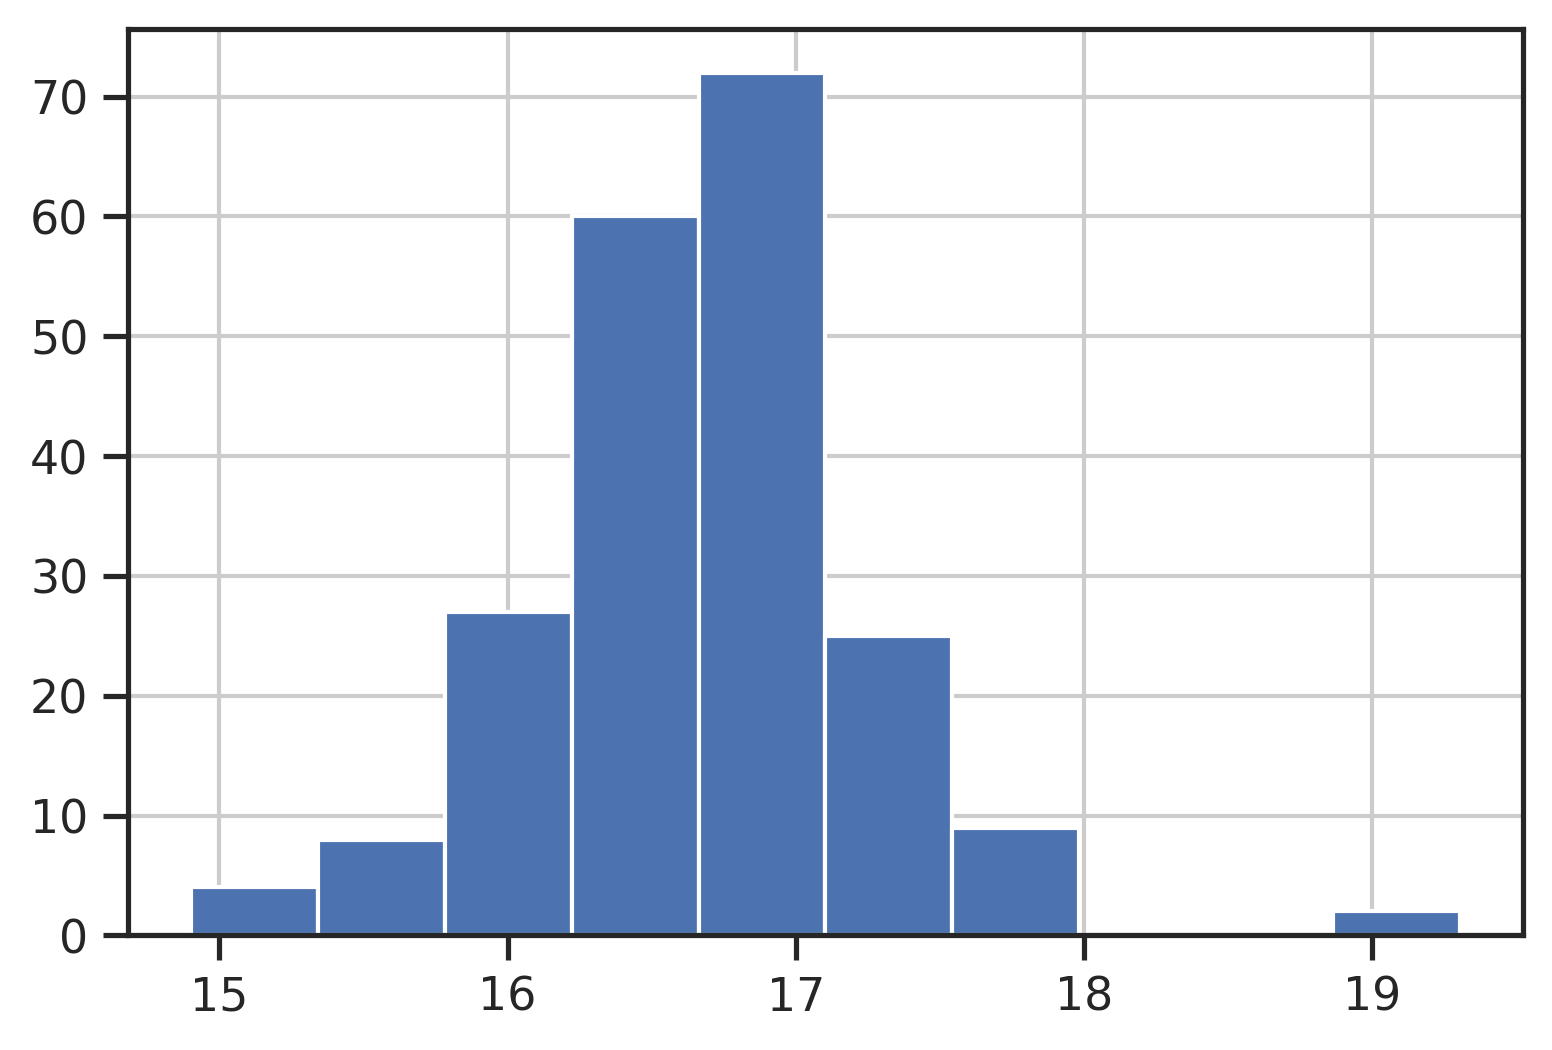

In [115]:
log.loc['AKT1'].hist()

Let's visualize kinase with strong signals vs. kinase with weak signals

In [126]:
# Rank average of each kinase
log.mean(axis=1).sort_values()

kinase
CK1G2       8.075914
GSK3B      12.901530
ALPHAK3    13.047268
CK1E       13.313101
VRK2       13.736377
             ...    
CDK5       19.250984
IRAK4      19.411939
IKKE       19.763757
TBK1       19.852895
MST2       19.994630
Length: 303, dtype: float64

<AxesSubplot:>

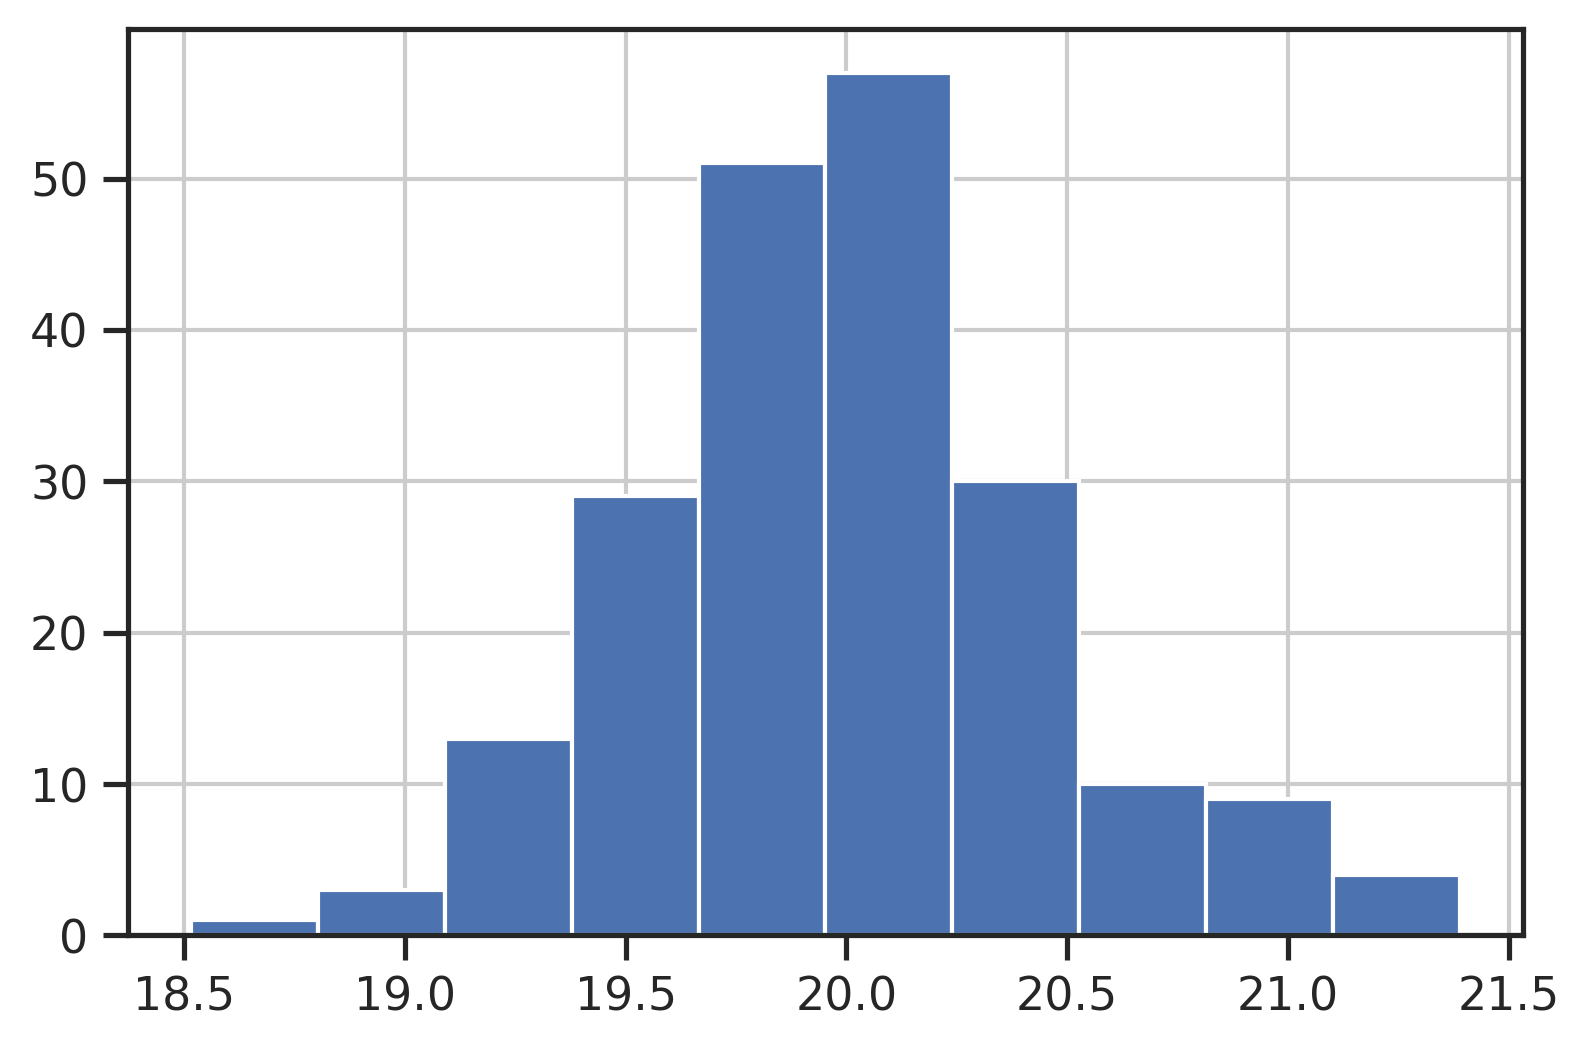

In [129]:
# Kinase with strong signal
log.loc['MST2'].hist()

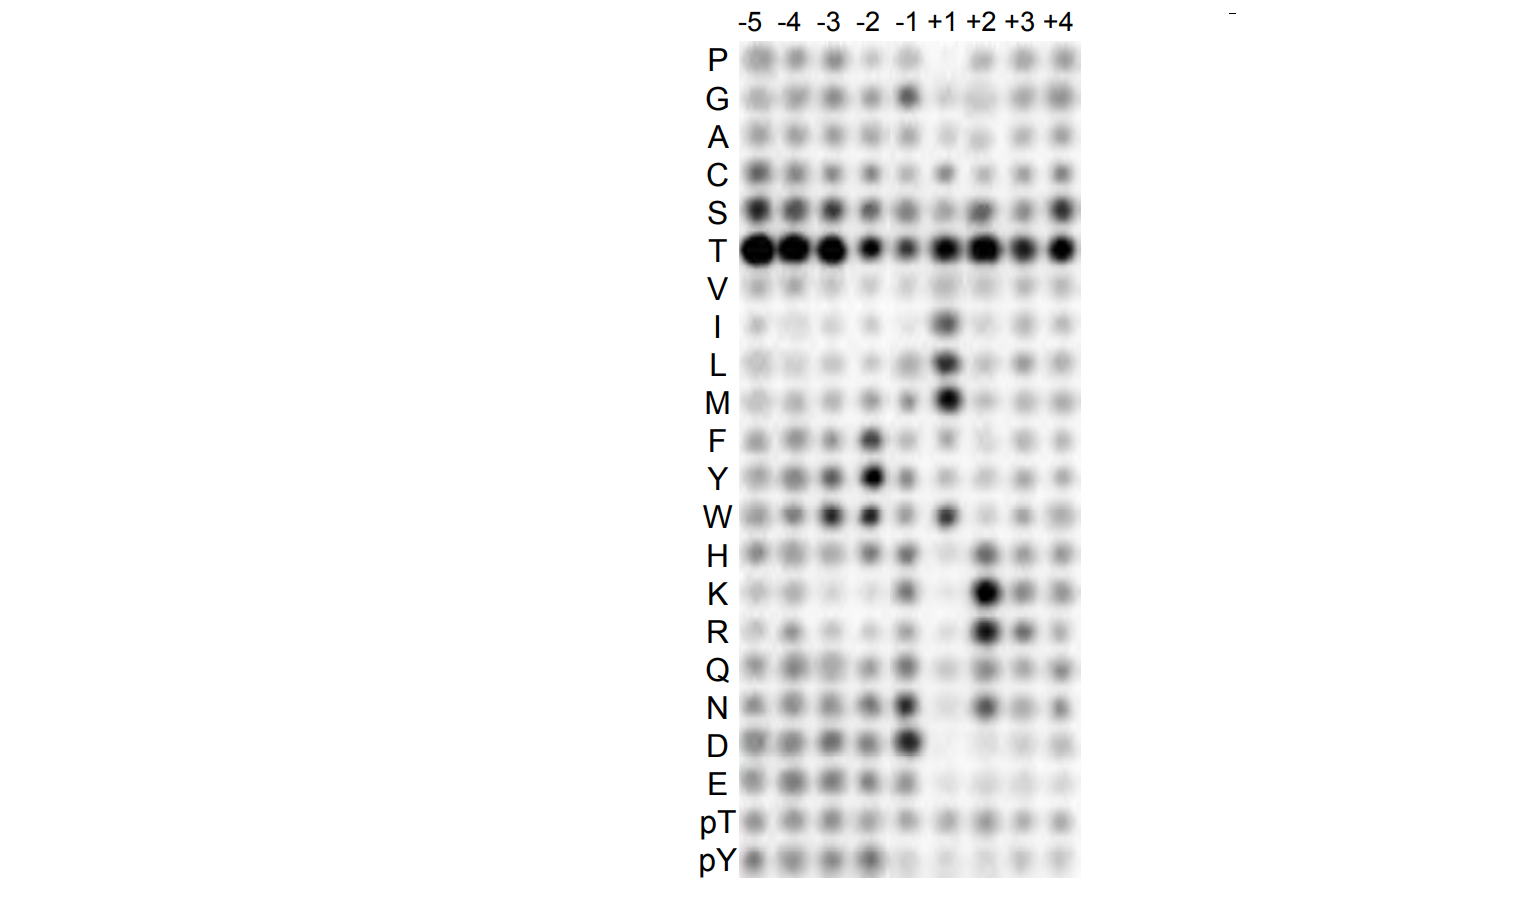

<AxesSubplot:>

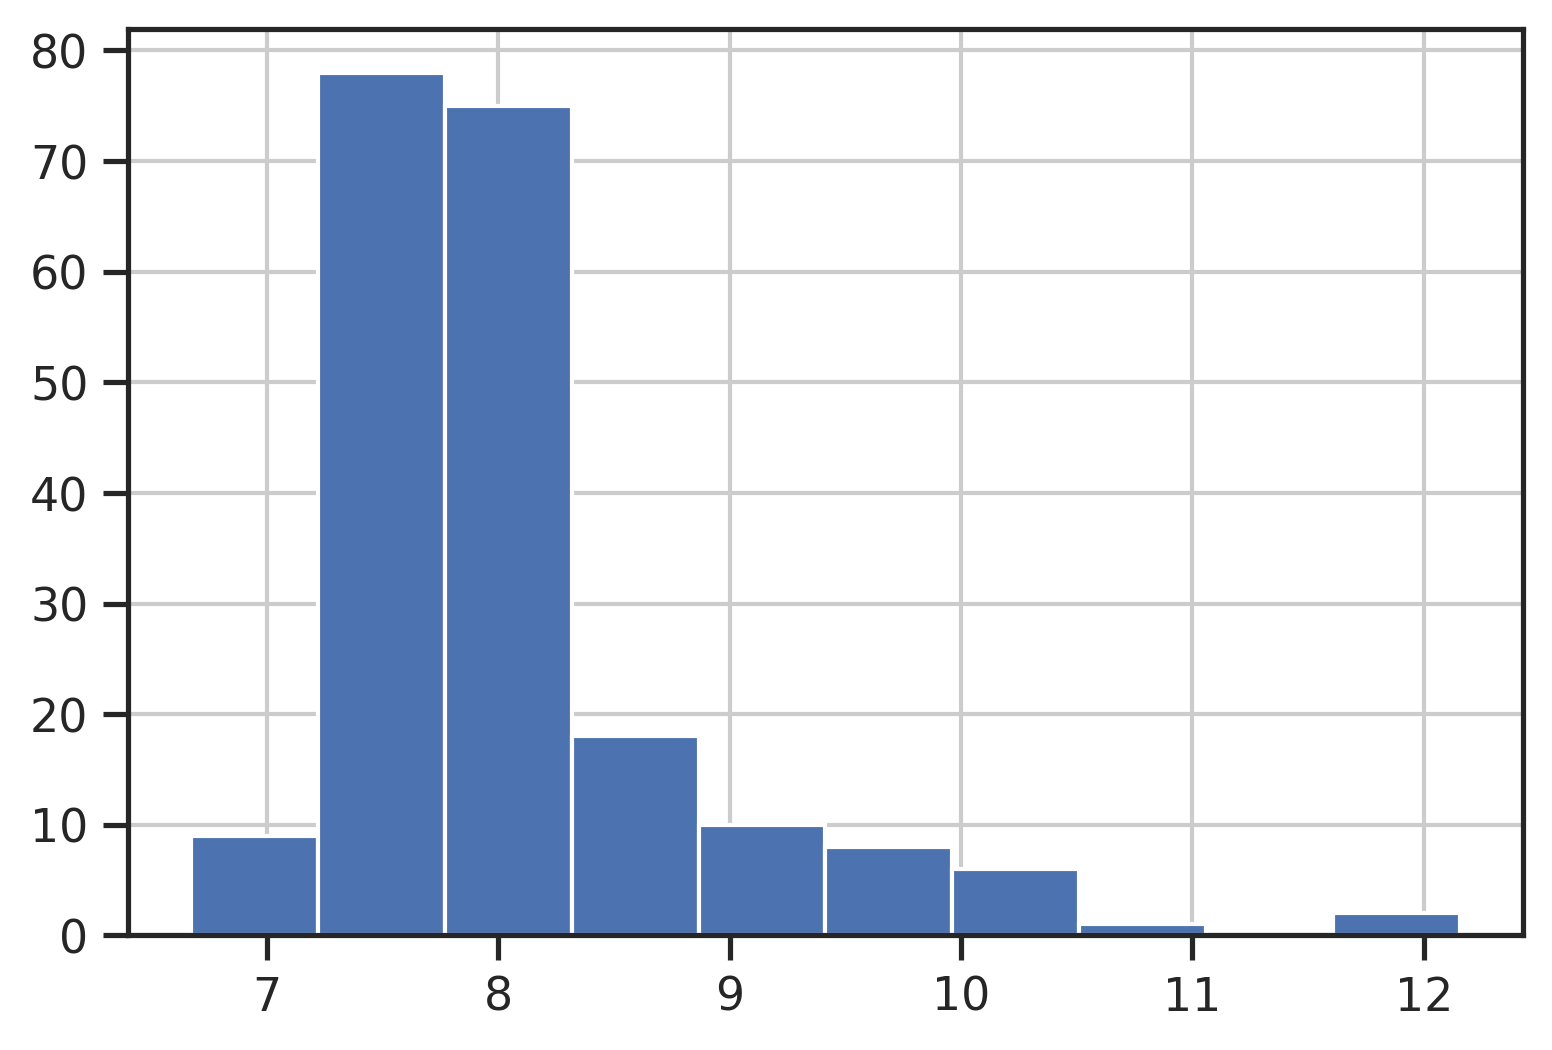

In [128]:
# Kinase with weak signal
log.loc['CK1G2'].hist()

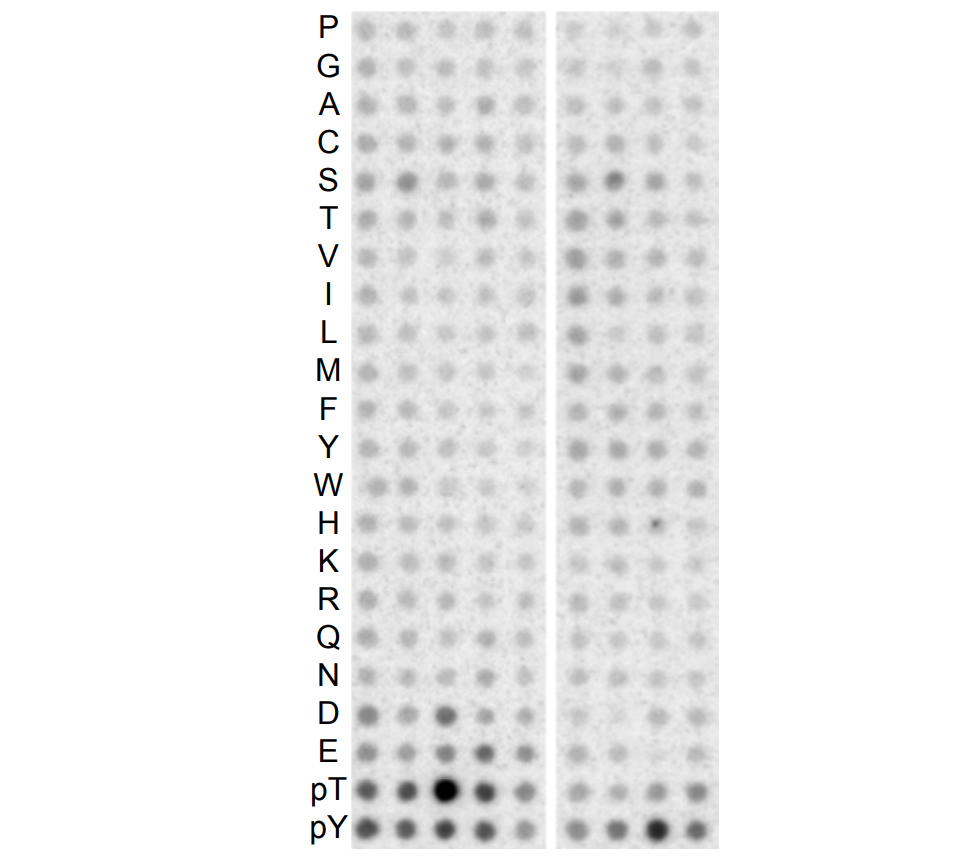

## Percentile Rank

A percentile rank of a score is the percentage of scores in its frequency distribution that are equal to or lower than it. The percentile rank can be a very useful tool when you want to know the relative position of a particular value within the distribution. The advantage of using percentile rank is that it provides a clear and interpretable understanding of the position of a score relative to others. However, one limitation is that it doesn't take into account the magnitude of scores - two very different scores could have the same percentile rank if they're higher than the same proportion of scores in the dataset.

In [97]:
rank = raw.rank(axis=1, pct=True)

<AxesSubplot:>

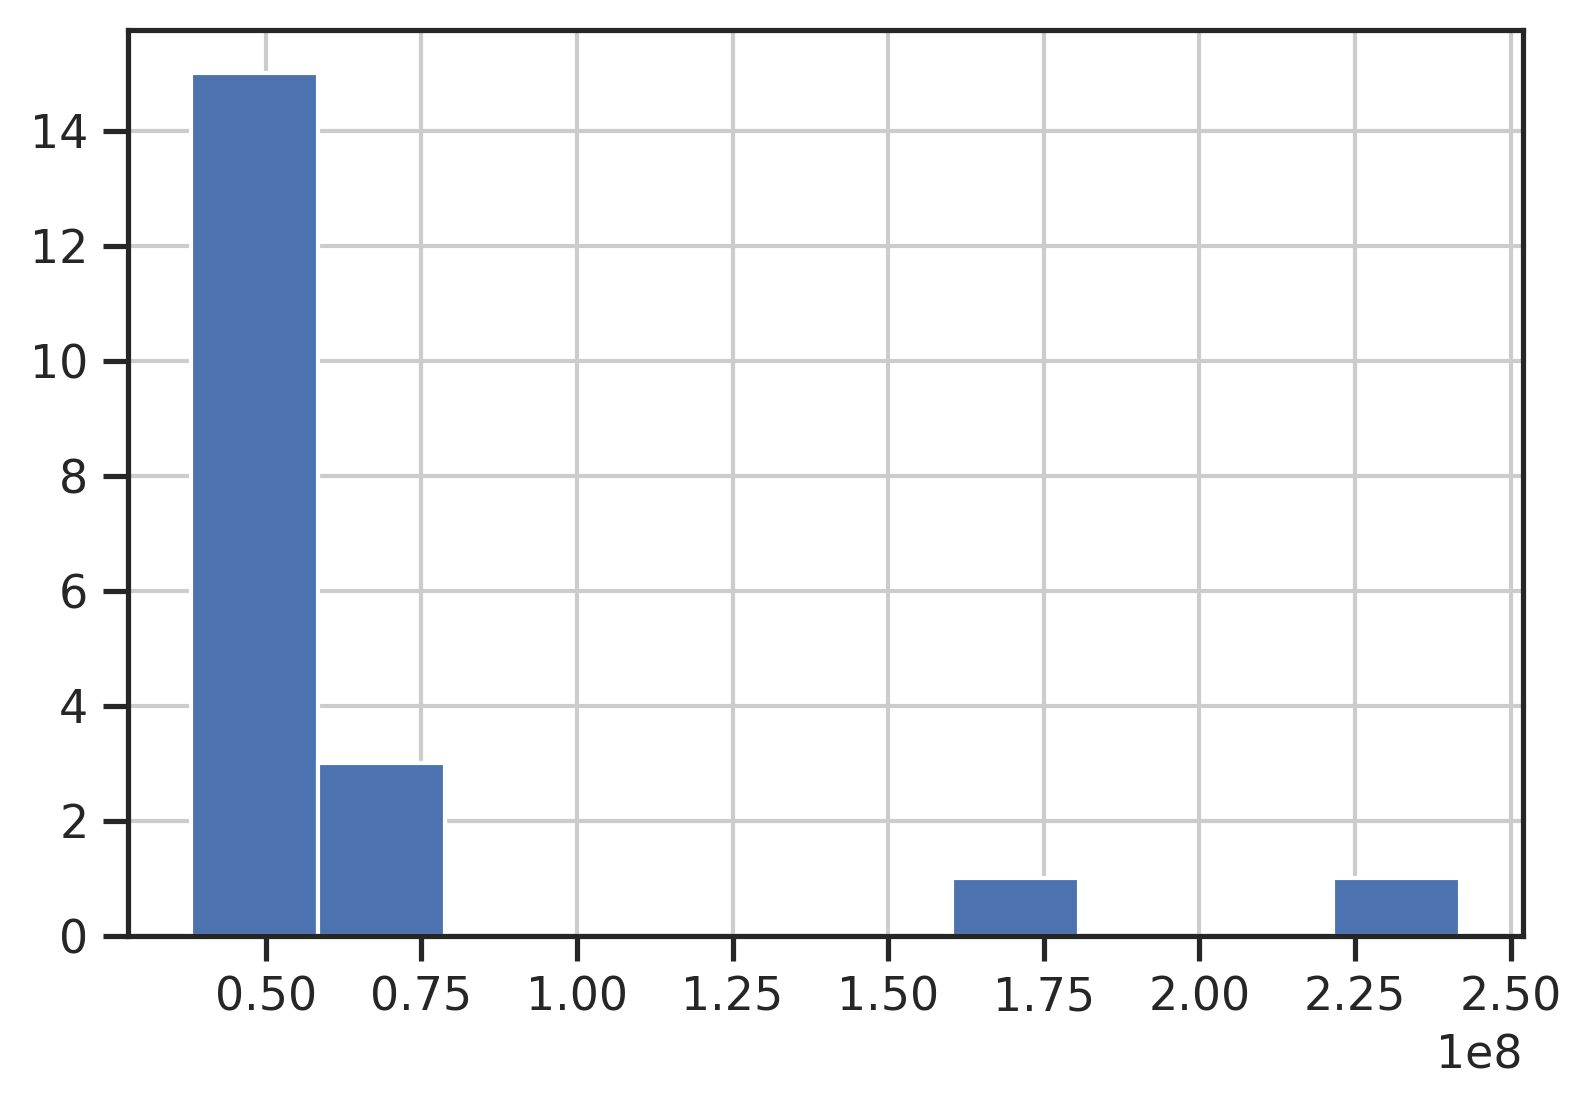

In [106]:
raw.loc['AKT1'].sort_values(ascending=False)[:20].hist()

<AxesSubplot:>

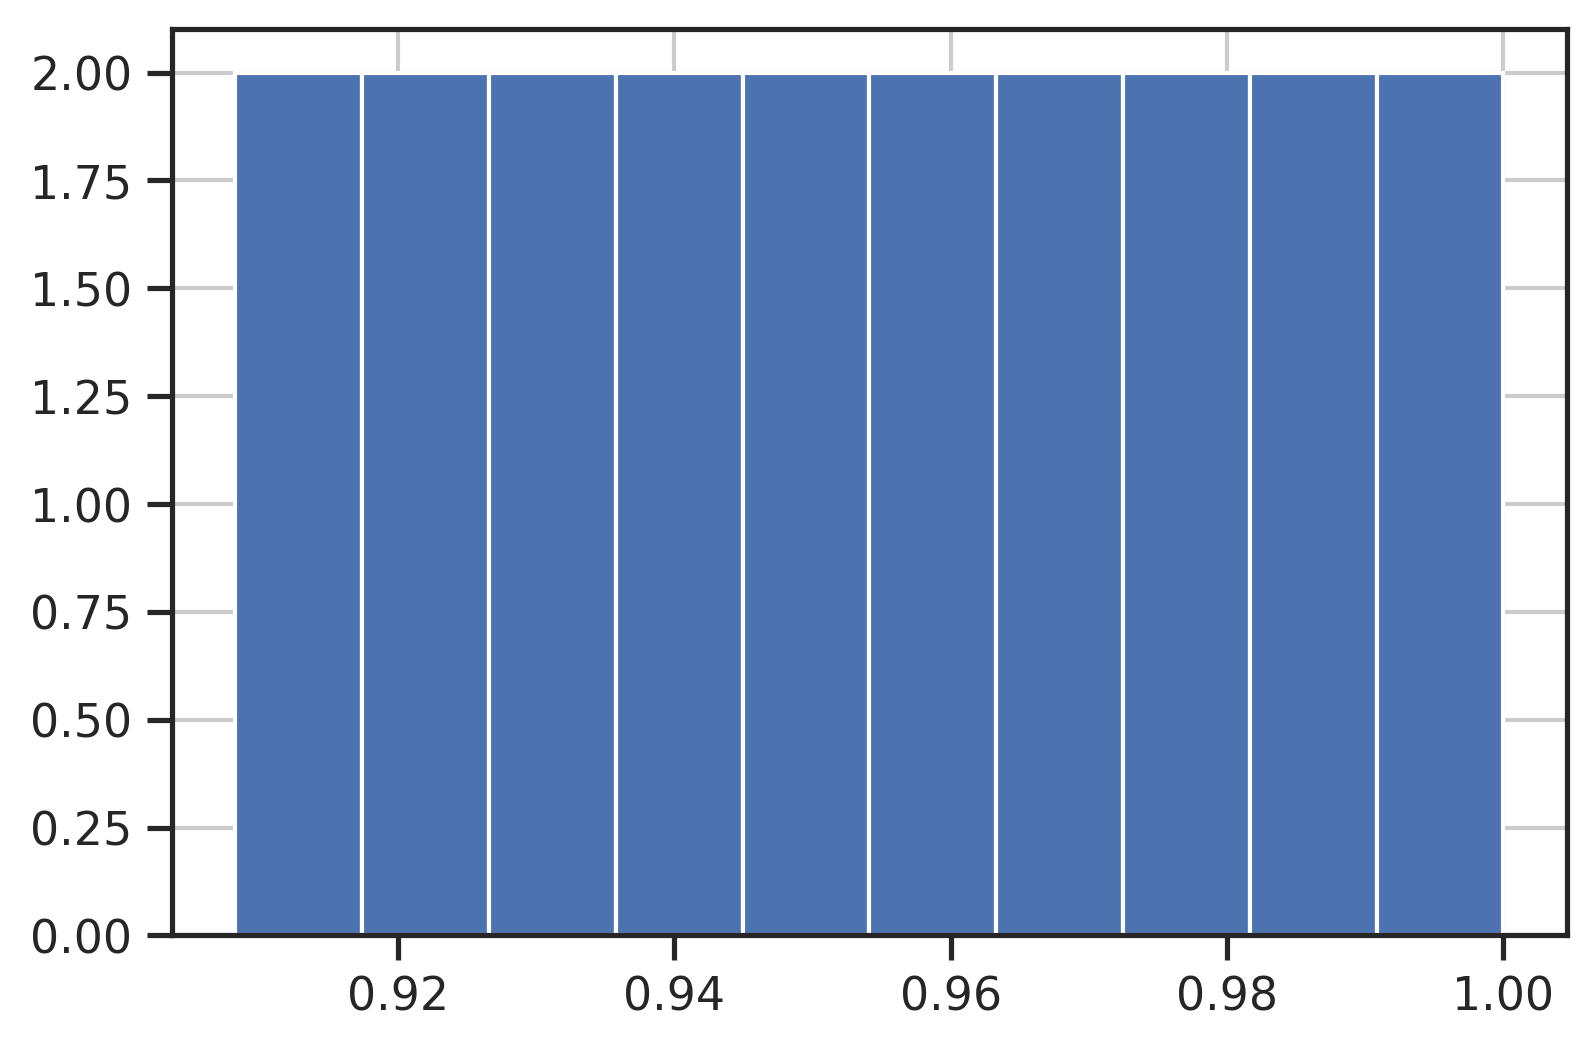

In [108]:
rank.loc['AKT1'].sort_values(ascending=False)[:20].hist()

After percentile ranking, values of each kinase are equally distributed, which eliminates their differences. Therefore, we will not choose this method.

## Post Process (unstack)

The following function will do several things:
- Unstack the dataframe for training purpose
- Add position and aa info
- Remove values of 's' of each kinase as it is a duplicate of 't'

In [161]:
def post_process(df):
    # Unstack
    df = df.unstack().reset_index(name = 'target')
    
    # Rename column
    df = df.rename(columns = {'level_0':'substrate'})
    
    # Reorder column
    df = df[['kinase','substrate','target']]
    
    # Deal with some warning issue
    df = df.copy()
    
    # Divide substrate info into position and aa
    df['position'] = df.substrate.str.extract('(-?\d+)')
    df['aa'] = df.substrate.str[-1]
    
    # Remove 's' as it is a duplicate of 't'
    df = df[df['aa'] != 's'].reset_index(drop=True)
    
    return df

In [174]:
scaled2 = post_process(scaled)

In [181]:
scaled2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,0.203681,-5,P
1,ACVR2A,-5P,-0.497906,-5,P
2,ACVR2B,-5P,-0.274530,-5,P
3,AKT1,-5P,-0.138624,-5,P
4,AKT2,-5P,-0.052269,-5,P


In [176]:
log2 = post_process(log)

In [180]:
log2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


In [179]:
# Uncheck to save to csv
# log2.to_csv('log_raw.csv',index=False)
# scaled2.to_csv('scaled_raw.csv',index=False)

## Download Directly

You can also download using Data

In [4]:
s = Data.get_standard_unstack()

In [4]:
s.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,0.203681,-5,P
1,ACVR2A,-5P,-0.497906,-5,P
2,ACVR2B,-5P,-0.274530,-5,P
3,AKT1,-5P,-0.138624,-5,P
4,AKT2,-5P,-0.052269,-5,P


In [5]:
log = Data.get_log_unstack()

In [6]:
log.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


## Stack back and convert back

If needed, we can also unstandardize back the data, and make a pivot table just like the raw data format

### Stack (pivot)

In [10]:
s2 = s.pivot_table(values='target', index='kinase', columns='substrate')
l2 = log.pivot_table(values='target', index='kinase', columns='substrate')

In [11]:
s2.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,-0.230001,-0.347964,-0.560306,-0.582931,0.005711,0.244323,0.218068,-0.156764,1.016970,0.167299,0.019240,-0.158167,0.879005,-0.212013,0.565143,-0.410233,-0.333834,-0.220053,-0.149010,0.348846,-0.619980,-0.535144,-0.104944,-0.060638,0.238376,0.021303,-0.365629,-0.434584,-0.068293,-0.311685,-0.041784,-0.064947,0.704582,0.242870,-0.507014,1.156807,-0.083634,-0.046250,0.312725,-0.360245,-0.425948,-0.284687,-0.528832,-0.172399,0.412796,-0.107899,-0.504666,-0.397831,-0.271350,-0.244453,-0.368338,-0.149962,-0.238815,-0.227701,0.048079,-0.168515,0.375777,-0.045824,-0.169834,0.088791,0.097927,-0.104745,-0.338815,-0.353372,-0.470989,-0.502068,0.117296,-0.091848,-0.368090,-0.073087,-0.124790,0.034068,-0.131928,0.007009,0.250337,0.163244,0.100403,-0.242082,-0.106215,0.014137,0.128231,-0.046494,0.071770,0.003501,-0.275465,-0.105830,-0.368540,-0.359225,-0.403626,-0.180427,-0.575591,-0.585769,-0.207229,-0.457705,-0.337347,1.364751,-0.434437,0.583590,0.403726,-0.41576,0.203681,-0.018879,0.531718,-0.147818,0.296065,0.525241,-0.360688,0.526055,-0.518516,0.051863,-0.230424,-0.402868,-0.611599,-0.619770,-0.563994,12.362261,-0.506806,-0.612825,-0.444817,-0.560260,-0.573473,-0.488266,0.045845,-0.547051,-0.344446,-0.437269,0.374306,-0.603431,-0.502948,-0.538152,-0.574161,-0.615814,0.160259,0.053669,-0.092480,-0.129028,-0.177423,0.159498,-0.006230,-0.325357,-0.060985,-0.269579,-0.183670,0.267692,-0.124799,0.187699,0.191370,0.284651,3.325393,-0.104782,-0.066707,-0.211718,-0.275257,-0.274150,0.086765,0.300182,-0.182819,-0.233565,-0.144839,0.605601,0.226128,-0.208888,0.325111,-0.055376,-0.134008,0.319800,0.237791,0.149084,0.571975,0.316905,3.972914,0.129336,-0.067498,0.011501,-0.289095,-0.253143,0.115644,0.03285,-0.247254,-0.150809,-0.057504,0.195092,-0.006110,-0.210472,0.377988,-0.145967,-0.141440,0.039153,0.090523,0.100903,0.515611,-0.028285,0.779315,-0.200421,0.371558,-0.060808,-0.442631,-0.415743
ACVR2A,-0.533758,1.866636,0.043243,0.132826,-0.043009,-0.890062,-0.183401,-0.559071,-0.943735,0.105184,0.339279,-0.542205,-0.740575,-0.424258,-0.879938,0.196536,0.297961,-0.134642,0.264999,0.185751,0.243869,0.863894,-0.748963,1.439747,5.981701,7.640885,-0.795231,-0.803114,-0.825693,-0.885805,-1.062971,-0.926676,-0.984152,-0.489129,-1.122702,-0.323497,-0.795169,0.582292,0.269968,-0.799173,-0.732187,-0.807462,0.108953,-0.409095,-0.320531,0.449682,0.995263,1.390984,-0.374182,-0.022480,-0.339023,-0.407179,-0.787150,-0.468623,-0.376245,-0.408686,-0.408744,-0.394222,-0.515491,0.435963,0.509886,-0.297263,-0.182125,-0.286429,1.391707,0.802355,-0.211803,0.403416,1.086241,0.628732,-0.040546,-0.227937,-0.221103,-0.287933,-0.609960,-0.304864,-0.153715,-0.355226,-0.450278,-0.405806,-0.472884,0.373043,0.454243,-0.241861,0.321310,-0.128993,0.467057,0.126918,-0.012000,0.312420,0.866593,0.581868,0.036466,-0.307642,-0.050572,0.107547,-0.223310,0.022588,-0.191905,-0.14868,-0.497906,-0.453912,-0.324180,0.001507,0.128542,0.029403,0.621488,-0.029054,0.564383,0.498567,-0.800305,0.810107,0.633966,2.745373,-0.406569,-0.899610,-0.727005,-0.069128,-1.243177,-0.487412,-0.317850,-

In [12]:
l2.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,15.278787,15.046350,14.409530,14.309843,15.625511,15.885259,15.859767,15.39991,16.439562,15.808548,15.642188,15.397722,16.360537,15.309924,16.153426,14.897700,15.077212,15.296126,15.411916,15.980756,14.121524,14.509843,15.477534,15.539435,15.879542,15.644706,15.006375,14.832977,15.529010,15.123752,15.564658,15.533580,16.250766,15.883865,14.611228,16.513754,15.507785,15.558741,15.948775,15.018728,14.856412,15.177698,14.533503,15.375256,16.034982,15.473266,14.619244,14.929123,15.203310,15.253050,15.000102,15.41045,15.263169,15.282823,15.676836,15.381438,16.003951,15.559307,15.379342,15.723790,15.734032,15.477821,15.066441,15.034280,14.727659,14.628040,15.755402,15.496233,15.000677,15.522426,15.448513,15.660153,15.437866,15.627123,15.891008,15.804342,15.736788,15.257317,15.475701,15.635929,15.767268,15.558416,15.704427,15.622760,15.195478,15.476257,14.999633,15.021053,14.914562,15.362356,14.343286,14.296608,15.318043,14.767386,15.069628,16.614806,14.833381,16.166861,16.027468,14.883373,15.845517,15.594467,16.128614,15.413749,15.933673,16.123734,15.017718,16.124349,14.571009,15.681294,15.278043,14.916479,14.167331,14.122693,14.393941,18.420330,14.611942,14.160760,14.804475,14.409722,14.352732,14.673508,15.674194,14.463624,15.054122,14.825578,16.002698,14.210045,14.625071,14.498366,14.349670,14.144557,15.801235,15.683415,15.49534,15.442205,15.367202,15.800441,15.610556,15.09528,15.538966,15.206662,15.357098,15.907416,15.448501,15.829445,15.833159,15.923192,17.259932,15.477768,15.531180,15.310426,15.195874,15.197988,15.721505,15.937426,15.358480,15.272501,15.418315,16.182658,15.867661,15.315236,15.959856,15.546540,15.434742,15.955120,15.878977,15.789514,16.158423,15.952528,17.405769,15.768459,15.530098,15.632682,15.169086,15.237248,15.753596,15.658689,15.247984,15.409144,15.543672,15.836912,15.610708,15.312547,16.005832,15.416588,15.423499,15.666239,15.725741,15.737345,16.116435,15.582333,16.299281,15.329487,16.000353,15.539205,14.810633,14.883416
ACVR2A,15.392766,16.513099,15.795955,15.846188,15.745082,15.026545,15.656307,15.37074,14.957600,15.830956,15.953165,15.385469,15.196757,15.482826,15.039034,15.880438,15.932652,15.688040,15.915980,15.874722,15.905145,16.182530,15.187935,16.385454,17.280967,17.476627,15.137829,15.129036,15.103414,15.031816,14.784947,14.980032,14.902352,15.430456,14.685785,15.559092,15.137898,16.065975,15.918511,15.133442,15.205501,15.124153,15.833046,15.494681,15.561252,16.005997,16.232581,16.369780,15.521456,15.757428,15.547713,15.49617,15.146764,15.447308,15.519894,15.494999,15.494954,15.506175,15.408364,15.999582,16.033673,15.578031,15.657151,15.585748,16.370014,16.158193,15.637348,15.984196,16.265830,16.086156,15.746572,15.626415,15.631061,15.584680,15.324934,15.572580,15.675747,15.535698,15.462148,15.497234,15.443830,15.969621,16.008121,15.616884,15.944296,15.691653,16.014064,15.842952,15.763671,15.939878,16.183584,16.065788,15.792051,15.570581,15.740496,15.832267,15.629563,15.784006,15.650669,15.679007,15.423155,15.459226,15.558595,15.771661,15.843843,15.787964,16.083035,15.753491,16.058082,16.02

In [16]:
# s2.to_csv('pivot_standard.csv')
# l2.to_csv('pivot_log.csv')

### Download stacked

The two stacked datasets are also available to download via Data

In [3]:
s2 = Data.get_standard_stack()
l2 = Data.get_log_stack()

In [4]:
s2.head(2)

,kinase,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
0,AAK1,-0.230001,-0.347964,-0.560306,-0.582931,0.005711,0.244323,0.218068,-0.156764,1.016970,0.167299,0.019240,-0.158167,0.879005,-0.212013,0.565143,-0.410233,-0.333834,-0.220053,-0.149010,0.348846,-0.619980,-0.535144,-0.104944,-0.060638,0.238376,0.021303,-0.365629,-0.434584,-0.068293,-0.311685,-0.041784,-0.064947,0.704582,0.242870,-0.507014,1.156807,-0.083634,-0.046250,0.312725,-0.360245,-0.425948,-0.284687,-0.528832,-0.172399,0.412796,-0.107899,-0.504666,-0.397831,-0.271350,-0.244453,-0.368338,-0.149962,-0.238815,-0.227701,0.048079,-0.168515,0.375777,-0.045824,-0.169834,0.088791,0.097927,-0.104745,-0.338815,-0.353372,-0.470989,-0.502068,0.117296,-0.091848,-0.368090,-0.073087,-0.124790,0.034068,-0.131928,0.007009,0.250337,0.163244,0.100403,-0.242082,-0.106215,0.014137,0.128231,-0.046494,0.071770,0.003501,-0.275465,-0.105830,-0.368540,-0.359225,-0.403626,-0.180427,-0.575591,-0.585769,-0.207229,-0.457705,-0.337347,1.364751,-0.434437,0.583590,0.403726,-0.41576,0.203681,-0.018879,0.531718,-0.147818,0.296065,0.525241,-0.360688,0.526055,-0.518516,0.051863,-0.230424,-0.402868,-0.611599,-0.619770,-0.563994,12.362261,-0.506806,-0.612825,-0.444817,-0.560260,-0.573473,-0.488266,0.045845,-0.547051,-0.344446,-0.437269,0.374306,-0.603431,-0.502948,-0.538152,-0.574161,-0.615814,0.160259,0.053669,-0.092480,-0.129028,-0.177423,0.159498,-0.006230,-0.325357,-0.060985,-0.269579,-0.183670,0.267692,-0.124799,0.187699,0.191370,0.284651,3.325393,-0.104782,-0.066707,-0.211718,-0.275257,-0.274150,0.086765,0.300182,-0.182819,-0.233565,-0.144839,0.605601,0.226128,-0.208888,0.325111,-0.055376,-0.134008,0.319800,0.237791,0.149084,0.571975,0.316905,3.972914,0.129336,-0.067498,0.011501,-0.289095,-0.253143,0.115644,0.03285,-0.247254,-0.150809,-0.057504,0.195092,-0.006110,-0.210472,0.377988,-0.145967,-0.141440,0.039153,0.090523,0.100903,0.515611,-0.028285,0.779315,-0.200421,0.371558,-0.060808,-0.442631,-0.415743
1,ACVR2A,-0.533758,1.866636,0.043243,0.132826,-0.043009,-0.890062,-0.183401,-0.559071,-0.943735,0.105184,0.339279,-0.542205,-0.740575,-0.424258,-0.879938,0.196536,0.297961,-0.134642,0.264999,0.185751,0.243869,0.863894,-0.748963,1.439747,5.981701,7.640885,-0.795231,-0.803114,-0.825693,-0.885805,-1.062971,-0.926676,-0.984152,-0.489129,-1.122702,-0.323497,-0.795169,0.582292,0.269968,-0.799173,-0.732187,-0.807462,0.108953,-0.409095,-0.320531,0.449682,0.995263,1.390984,-0.374182,-0.022480,-0.339023,-0.407179,-0.787150,-0.468623,-0.376245,-0.408686,-0.408744,-0.394222,-0.515491,0.435963,0.509886,-0.297263,-0.182125,-0.286429,1.391707,0.802355,-0.211803,0.403416,1.086241,0.628732,-0.040546,-0.227937,-0.221103,-0.287933,-0.609960,-0.304864,-0.153715,-0.355226,-0.450278,-0.405806,-0.472884,0.373043,0.454243,-0.241861,0.321310,-0.128993,0.467057,0.126918,-0.012000,0.312420,0.866593,0.581868,0.036466,-0.307642,-0.050572,0.107547,-0.223310,0.022588,-0.191905,-0.14868,-0.497906,-0.453912,-0.324180,0.001507,0.128542,0.029403,0.621488,-0.029054,0.564383,0.498567,-0.800305,0.810107,0.633966,2.745373,-0.406569,-0.899610,-0.727005,-0.069128,-1.243177,-0.487412,-0.317850,-0.812482,-1.224733,0.005214,-1.119845,-0.038468,0.166344,0.137770,-0.365343,-0.352363,4.737421,2.189140,-0.098968,0.370387,0.066374,-0.234391,-0.295696,0.237708,-0.097891,-0.393253,-0.550023,-0.735734,-0

In [5]:
l2.head(2)

,kinase,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
0,AAK1,15.278787,15.046350,14.409530,14.309843,15.625511,15.885259,15.859767,15.39991,16.439562,15.808548,15.642188,15.397722,16.360537,15.309924,16.153426,14.897700,15.077212,15.296126,15.411916,15.980756,14.121524,14.509843,15.477534,15.539435,15.879542,15.644706,15.006375,14.832977,15.529010,15.123752,15.564658,15.533580,16.250766,15.883865,14.611228,16.513754,15.507785,15.558741,15.948775,15.018728,14.856412,15.177698,14.533503,15.375256,16.034982,15.473266,14.619244,14.929123,15.203310,15.253050,15.000102,15.41045,15.263169,15.282823,15.676836,15.381438,16.003951,15.559307,15.379342,15.723790,15.734032,15.477821,15.066441,15.034280,14.727659,14.628040,15.755402,15.496233,15.000677,15.522426,15.448513,15.660153,15.437866,15.627123,15.891008,15.804342,15.736788,15.257317,15.475701,15.635929,15.767268,15.558416,15.704427,15.622760,15.195478,15.476257,14.999633,15.021053,14.914562,15.362356,14.343286,14.296608,15.318043,14.767386,15.069628,16.614806,14.833381,16.166861,16.027468,14.883373,15.845517,15.594467,16.128614,15.413749,15.933673,16.123734,15.017718,16.124349,14.571009,15.681294,15.278043,14.916479,14.167331,14.122693,14.393941,18.420330,14.611942,14.160760,14.804475,14.409722,14.352732,14.673508,15.674194,14.463624,15.054122,14.825578,16.002698,14.210045,14.625071,14.498366,14.349670,14.144557,15.801235,15.683415,15.49534,15.442205,15.367202,15.800441,15.610556,15.09528,15.538966,15.206662,15.357098,15.907416,15.448501,15.829445,15.833159,15.923192,17.259932,15.477768,15.531180,15.310426,15.195874,15.197988,15.721505,15.937426,15.358480,15.272501,15.418315,16.182658,15.867661,15.315236,15.959856,15.546540,15.434742,15.955120,15.878977,15.789514,16.158423,15.952528,17.405769,15.768459,15.530098,15.632682,15.169086,15.237248,15.753596,15.658689,15.247984,15.409144,15.543672,15.836912,15.610708,15.312547,16.005832,15.416588,15.423499,15.666239,15.725741,15.737345,16.116435,15.582333,16.299281,15.329487,16.000353,15.539205,14.810633,14.883416
1,ACVR2A,15.392766,16.513099,15.795955,15.846188,15.745082,15.026545,15.656307,15.37074,14.957600,15.830956,15.953165,15.385469,15.196757,15.482826,15.039034,15.880438,15.932652,15.688040,15.915980,15.874722,15.905145,16.182530,15.187935,16.385454,17.280967,17.476627,15.137829,15.129036,15.103414,15.031816,14.784947,14.980032,14.902352,15.430456,14.685785,15.559092,15.137898,16.065975,15.918511,15.133442,15.205501,15.124153,15.833046,15.494681,15.561252,16.005997,16.232581,16.369780,15.521456,15.757428,15.547713,15.49617,15.146764,15.447308,15.519894,15.494999,15.494954,15.506175,15.408364,15.999582,16.033673,15.578031,15.657151,15.585748,16.370014,16.158193,15.637348,15.984196,16.265830,16.086156,15.746572,15.626415,15.631061,15.584680,15.324934,15.572580,15.675747,15.535698,15.462148,15.497234,15.443830,15.969621,16.008121,15.616884,15.944296,15.691653,16.014064,15.842952,15.763671,15.939878,16.183584,16.065788,15.792051,15.570581,15.740496,15.832267,15.629563,15.784006,15.650669,15.679007,15.423155,15.459226,15.558595,15.771661,15.843843,15.787964,16.083035,15.753491,16.058082,16.028528,15.132179,16.161292,16.088405,16.733580,15.496643,15.014623,15.210864,15.729152,14.449733,15.431878,15.563200,15.118485,14.489685,15.773843,14.690758,15.747826,15.864354,15.848889,15.528122,15.53783

### Unstandardize

In [18]:
scaler = load('standard_scaler.joblib')

In [59]:
unscaled = (s2.T* scaler.scale_) + scaler.mean_

In [ ]:
unscaled = unscaled.T

Let's compare the unscaled with the raw data!

In [61]:
raw2 = raw[unscaled.columns]

In [65]:
raw2.head(2)

,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.90,537481

In [66]:
unscaled.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.

Same!

### Log back

In [67]:
unlog = np.exp(l2)

In [70]:
raw2.head(2)

,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.90,537481

In [69]:
unlog.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320089.81,3424102.65,1811254.16,1639404.12,6110447.84,7922826.91,7723413.28,4876362.62,13791486.68,7337789.35,6213209.09,4865706.32,12743567.74,4456719.79,10359622.72,2951132.47,3531425.24,4395649.71,4935260.96,8716737.64,1358000.07,2002372.19,5269961.36,5606489.15,7877661.92,6228873.38,3289922.82,2766178.13,5548345.99,3699661.08,5749699.72,5573759.37,11418740.19,7911792.51,2216029.59,14853624.17,5431821.79,5715777.94,8442377.88,3330816.96,2831768.59,3904725.03,2050312.16,4757609.56,9202468.84,5247518.95,2233865.71,3045338.18,4006023.34,4210323.63,3269350.53,4928032.78,4253144.83,4337562.80,6432257.95,4787113.42,8921288.46,5719014.51,4777088.04,6741481.38,6810878.54,5271477.43,3493592.45,3383023.36,2489665.19,2253601.17,6957994.77,5369435.90,3271231.67,5511934.84,5119222.55,6325835.43,5065008.89,6120309.98,7968512.43,7306989.18,6829678.84,4228328.20,5260313.92,6174444.51,7041050.08,5713921.54,6612202.68,6093663.03,3974772.07,5263236.93,3267818.62,3338570.94,3001316.49,4696632.43,1695156.97,1617849.59,4493054.86,2590564.43,3504743.95,16433062.43,2767295.24,10499736.53,9133578.86,2909153.87,7614135.38,5923674.04,10105743.33,4944312.77,8315838.72,10056546.00,3327455.51,10062729.22,2128671.48,6460995.89,4316875.96,3007075.62,1421653.45,1359588.84,1783237.05,99964896.25,2217613.04,1412341.64,2688448.64,1811601.47,1711245.81,2358433.64,6415287.88,1911930.56,3450818.64,2745786.51,8910121.32,1483693.44,2246920.31,1979522.48,1706014.09,1389642.63,7284323.40,6474715.78,5364639.21,5087032.12,4719446.91,7278541.04,6019748.75,3595812.04,5603859.75,4019475.24,4672001.36,8100332.77,5119158.71,7492738.30,7520621.82,8229141.75,31325168.00,5271195.4,5560395.09,4458959.54,3976346.18,3984760.21,6726093.35,8347111.75,4678463.79,4293020.55,4966941.21,10666926.10,7784626.71,4480459.41,8536455.84,5646462.38,5049206.04,8496116.61,7873215.56,7199440.88,10411517.21,8474127.59,36243426.13,7049440.08,5554385.65,6154423.64,3871243.35,4144315.24,6945442.59,6316584.85,4189046.89,4921596.57,5630293.14,7548894.13,6020663.73,4468426.80,8938082.41,4958372.35,4992758.20,6364454.29,6754641.94,6833482.55,9983403.01,5852228.64,11986374.78,4544766.44,8889243.83,5605200.37,2705054.53,2909280.71
ACVR2A,4841647.42,14843897.03,7245965.01,7619249.38,6886560.95,3356956.48,6301557.70,4736172.24,3133306.90,7504066.67,8479524.23,4806450.34,3979857.52,5297926.78,3399145.04,7884722.89,8307356.21,6504732.08,8170004.32,7839786.04,8081958.45,10665552.58,3944903.95,13065087.92,31991049.32,38904734.20,3752111.50,3719261.44,3625178.90,3374695.08,2636457.76,3204388.82,2964893.35,5027611.59,2387567.18,5717786.76,3752367.69,9492140.23,8190709.05,3735686.73,4014812.08,3701144.76,7519771.93,5361108.35,5730146.40,8939564.00,11212958.52,12861895.95,5506588.16,6972104.63,5653092.40,5369093.23,3785784.33,5113058.94,5497994.14,5362813.26,5362571.64,5423082.45,4917763.58,8882397.89,9190427.82,5827105.19,6306876.17,5872247.52,12864906.98,10409125.62,6183208.45,8746775.91,11592054.32,9685650.12,6896824.79,6115978.27,6144456.59,5865980.65,4524122.26,5795430.17,6425255.28,5585577.72,5189501.

Same!

# Plot

## Distribution

### Raw data

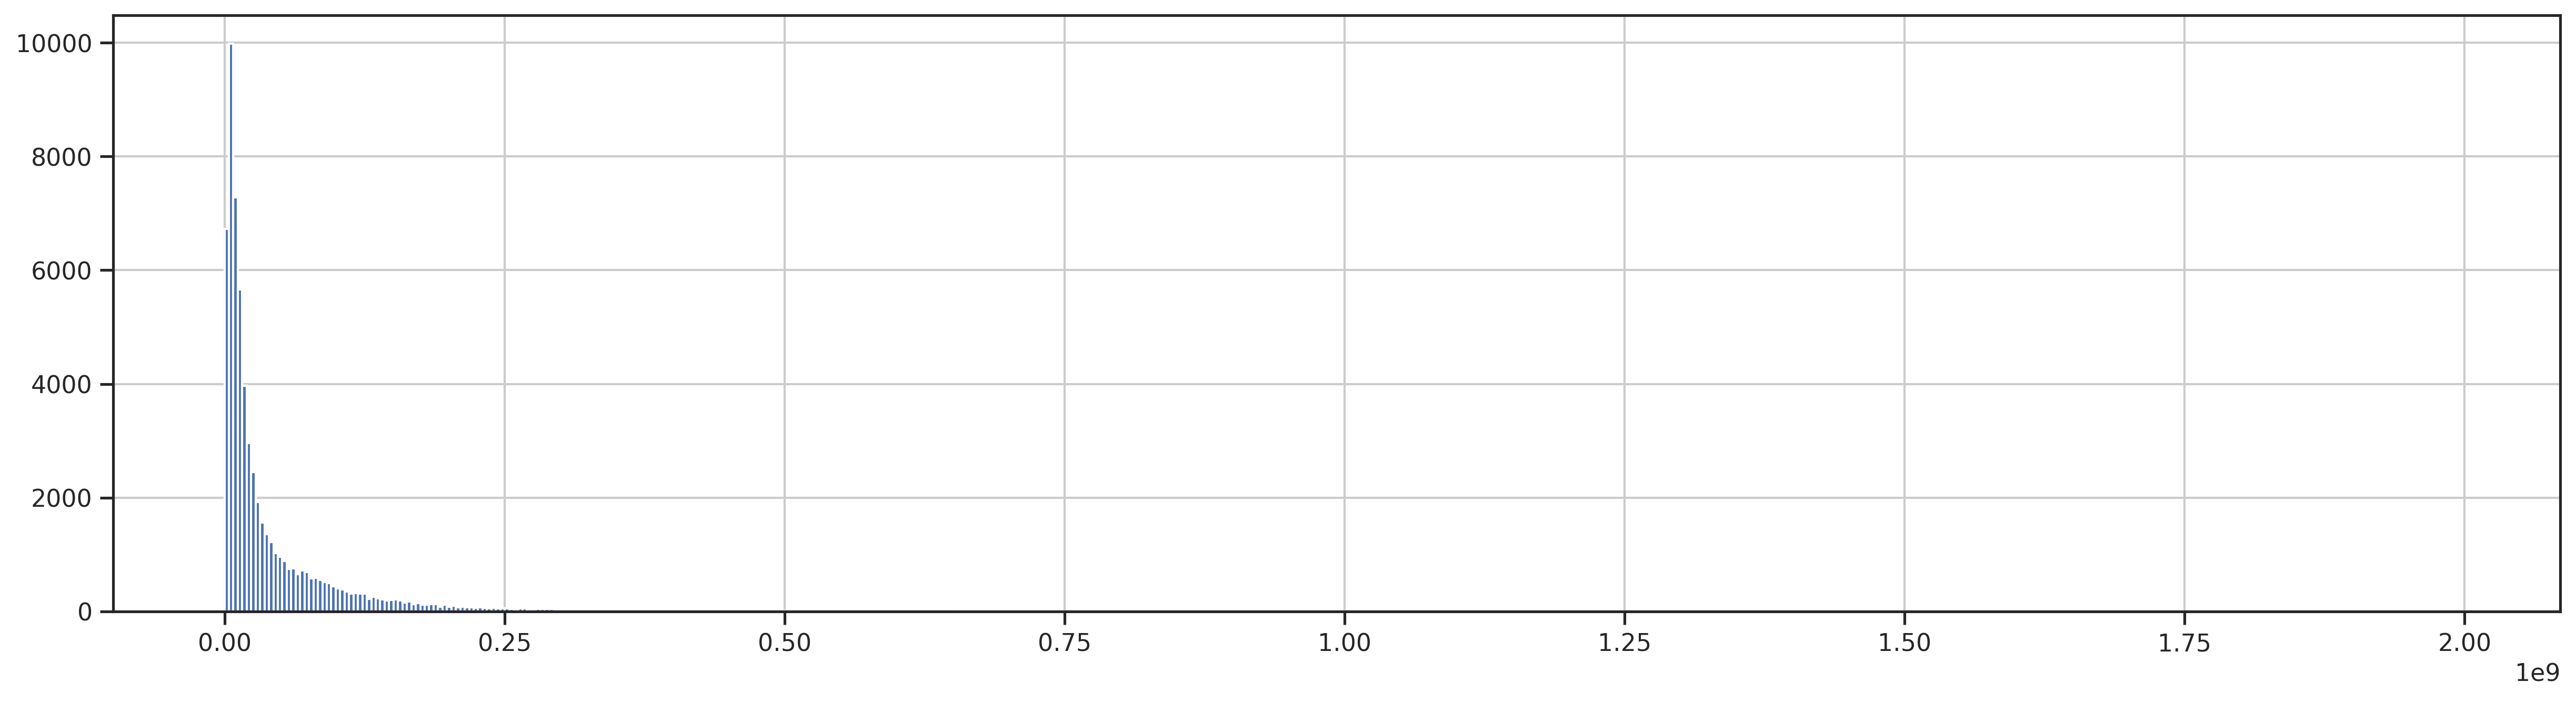

In [89]:
raw_unstack = raw.unstack().reset_index(name='target')
raw_unstack.target.hist(bins=500,figsize=(20,5));

### Standardized

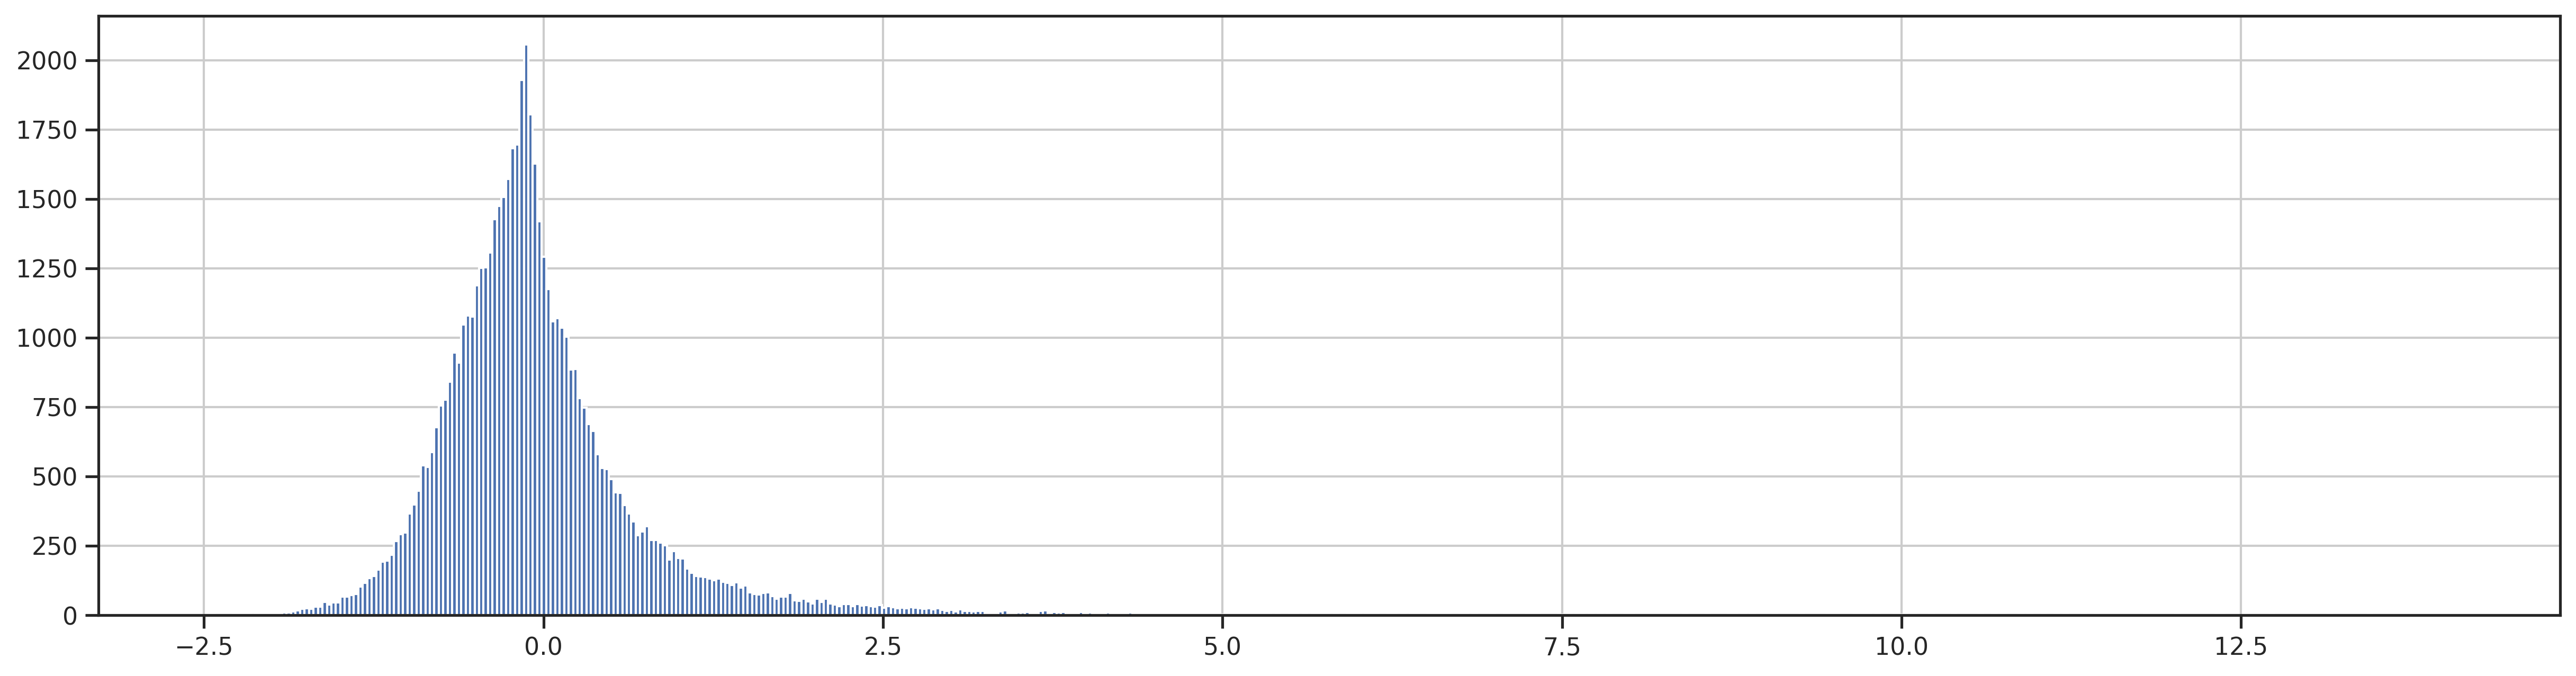

In [77]:
s.target.hist(bins=500,figsize=(20,5));

### Log transformed

There's an outlier at lower position

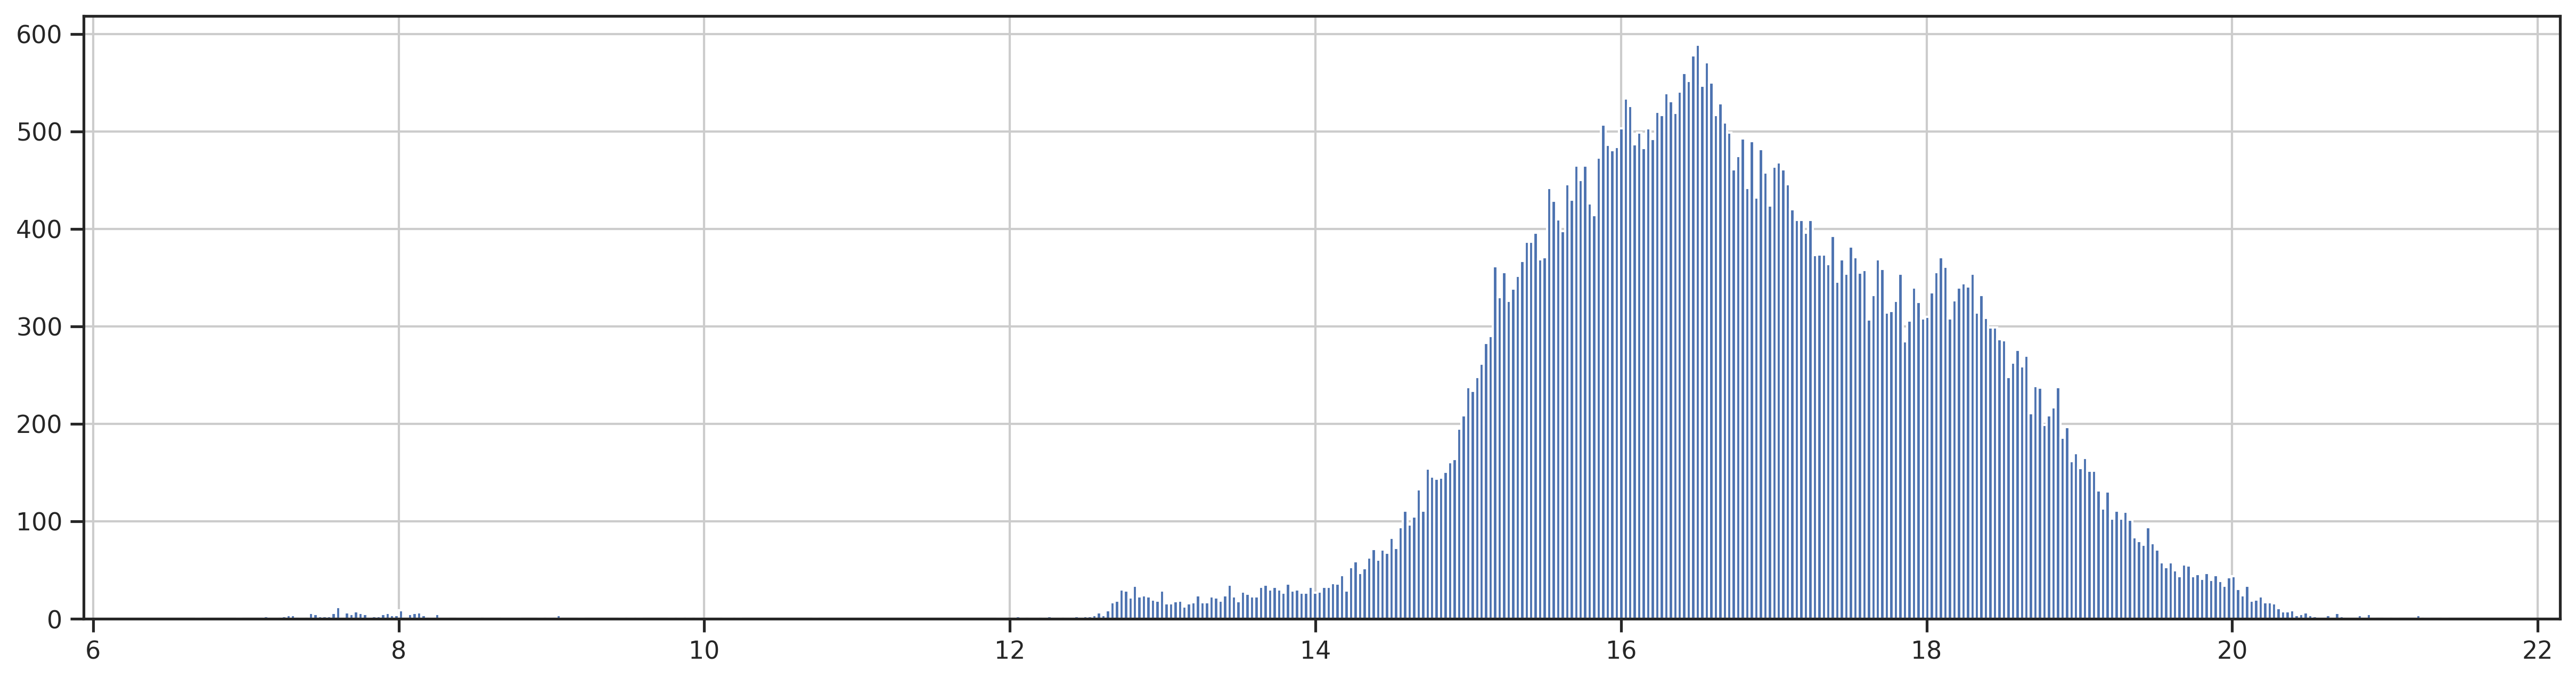

In [76]:
log.target.hist(bins=500,figsize=(20,5));

Let's remove the outlier

In [10]:
log.groupby('kinase').target.mean().sort_values()

kinase
CK1G2       8.011314
GSK3B      12.876897
ALPHAK3    13.030494
CK1E       13.279775
VRK2       13.745083
             ...    
CDK5       19.266964
IRAK4      19.439014
IKKE       19.768584
TBK1       19.861380
MST2       19.994227
Name: target, Length: 303, dtype: float64

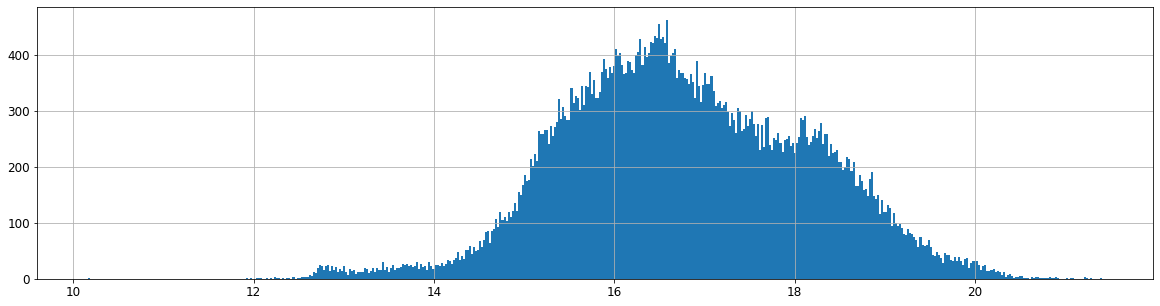

In [13]:
log.query('kinase != "CK1G2"').target.hist(bins=500,figsize=(20,5));